In [1]:
from lgdo import lh5
import awkward as ak
import glob
import hist
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 3)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt

import torch as torch
import torch.nn as nn

# Importing Data and Data Pre-processing

In [3]:
import h5py

filename = "MJD_Train_1.hdf5"
with h5py.File(filename, "r") as f:
    print("Keys at root:", list(f.keys()))
    # For example you might see something like: "raw_waveform", "energy_label", "psd_label_low_avse", ...
    for key in f.keys():
        print(key, f[key].shape, f[key].dtype)

Keys at root: ['detector', 'energy_label', 'id', 'psd_label_dcr', 'psd_label_high_avse', 'psd_label_low_avse', 'psd_label_lq', 'raw_waveform', 'run_number', 'tp0']
detector (65000,) int64
energy_label (65000,) float64
id (65000,) int64
psd_label_dcr (65000,) bool
psd_label_high_avse (65000,) bool
psd_label_low_avse (65000,) bool
psd_label_lq (65000,) bool
raw_waveform (65000, 3800) float64
run_number (65000,) int64
tp0 (65000,) int64


In [4]:
with h5py.File(filename, "r") as f:
    # Check available keys first
    print("Keys:", list(f.keys()))
    
    waveforms = f["raw_waveform"][:]                
    sse_label = f["psd_label_low_avse"][:]
    energy_label = f["energy_label"][:]

# Combine conditions: single-site AND energy between 30 and 1500 keV
combined_indices = np.where(
    (sse_label == 1) & (energy_label >= 30) & (energy_label <= 1500)
)[0]

# Extract the waveforms and energies
selected_waveforms = waveforms[combined_indices]
selected_energies = energy_label[combined_indices]

print(f"Found {len(selected_waveforms)} single-site events in 30–1500 keV range")

Keys: ['detector', 'energy_label', 'id', 'psd_label_dcr', 'psd_label_high_avse', 'psd_label_low_avse', 'psd_label_lq', 'raw_waveform', 'run_number', 'tp0']
Found 25403 single-site events in 30–1500 keV range


## Filtering Noisy Waveforms and Clean Waveforms

In [5]:
# Choose baseline region (first 1000 samples)
baseline_region = slice(0, 1000)

# Compute SNR and amplitude for all single-site waveforms
snr_list = []
amp_list = []
energy_list = []

for idx in range(len(selected_waveforms)):
    wf = selected_waveforms[idx]
    baseline = wf[baseline_region]
    
    baseline_mean = np.mean(baseline)
    baseline_std = np.std(baseline)
    amplitude = np.max(wf) - baseline_mean
    energy = selected_energies[idx]
    # Avoid division by zero
    snr = 20 * np.log10(amplitude / baseline_std) if baseline_std > 0 else np.nan
    
    amp_list.append(amplitude)
    snr_list.append(snr)
    energy_list.append(energy)
    
snr_list = np.array(snr_list)
amp_list = np.array(amp_list)
energy_list = np.array(energy_list)

print(f"Computed SNRs for {len(snr_list)} single-site events")

# Define baseline region (first 1000 samples)
baseline_region = slice(0, 1000)

# Sort indices by SNR
sorted_indices = np.argsort(snr_list)
low_snr_indices = sorted_indices[:1000]
high_snr_indices = sorted_indices[-1000:]

Computed SNRs for 25403 single-site events


## Adding Noise to Clean Waveforms and Data Augmentation

In [6]:
method = "target_snr"  
SNR_targets = [5, 10, 50, 100]  # 5 different SNR values

# Choose the high-SNR waveforms (use your existing index array)
high_waveforms = selected_waveforms[high_snr_indices]

# Function to add physics-based Johnson noise (converted to ADC counts)
def add_physics_johnson_noise(wf, kB, T, R, B, v_per_count):
    sigma_V = np.sqrt(4.0 * kB * T * R * B)   # RMS voltage
    sigma_counts = sigma_V / v_per_count
    noise = np.random.normal(loc=0.0, scale=sigma_counts, size=wf.shape)
    return wf + noise, sigma_counts

# Function to add Gaussian noise to produce a target SNR (defined using peak amplitude)
def add_target_snr_noise(wf, baseline_region=slice(0,1000), snr_target=50.0):
    baseline = wf[baseline_region]
    baseline_mean = np.mean(baseline)
    amplitude = np.max(wf) - baseline_mean
    sigma = amplitude / snr_target if snr_target > 0 else 0.0
    noise = np.random.normal(loc=0.0, scale=sigma, size=wf.shape)
    return wf + noise, sigma 

In [7]:
def shift_baseline(wf, direction, baseline_region=slice(0,1000), offset_max=300, offset_min=200):
    """
    Shift waveform baseline so it becomes negative.
    offset_min, offset_max must both be negative.
    """
    baseline = wf[baseline_region]
    baseline_mean = np.mean(baseline)

    # Pick a negative offset from the range
    offset = np.random.uniform(offset_max, offset_min)

    # If baseline + offset is still positive, shift more

    if direction == "up":
        return wf + offset
    elif direction == "down":
        return wf - offset
    else:
        return wf

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models


In [9]:
clean = np.array(high_waveforms, dtype=np.float32)

# Repeat each clean waveform 6 times
clean = np.repeat(clean, 6, axis=0)   # Now clean.shape = (6000, L)

noisy = []
clean_shifted = []
snr_labels = []  # Optional: track which SNR was used for each waveform

N = clean.shape[0]
indices_unshifted = slice(0, 3000)
indices_down = slice(3000, 6000)

# Calculate the number of waveforms per SNR level (1/4 of total)
n_per_snr = N // 4

for i, wf in enumerate(clean):
    # Determine baseline shift
    if i in range(*indices_down.indices(N)):
        wf_shifted = shift_baseline(wf, direction="down")  # shifted downward
    else:
        wf_shifted = wf  # unshifted

    clean_shifted.append(wf_shifted)

    # Determine which SNR to use based on index
    snr_index = min(i // n_per_snr, len(SNR_targets) - 1)  # Ensure we don't go out of bounds
    current_snr = SNR_targets[snr_index]
    snr_labels.append(current_snr)

    # Generate noisy version with the current SNR
    if method == "physics":
        n, _ = add_physics_johnson_noise(
            wf_shifted, kB, T, R, B, v_per_count
        )
    else:
        n, _ = add_target_snr_noise(
            wf_shifted,
            baseline_region=slice(0, 1000),
            snr_target=current_snr
        )
    noisy.append(n)

# Convert to arrays
clean_shifted = np.array(clean_shifted, dtype=np.float32)
noisy = np.array(noisy, dtype=np.float32)
snr_labels = np.array(snr_labels, dtype=np.float32)

print("Clean shifted shape: ", clean_shifted.shape)
print("Noisy shape: ", noisy.shape)
print("SNR distribution:")
for snr in SNR_targets:
    count = np.sum(snr_labels == snr)
    print(f"  SNR={snr}: {count} waveforms")

Clean shifted shape:  (6000, 3800)
Noisy shape:  (6000, 3800)
SNR distribution:
  SNR=5: 1500 waveforms
  SNR=10: 1500 waveforms
  SNR=50: 1500 waveforms
  SNR=100: 1500 waveforms


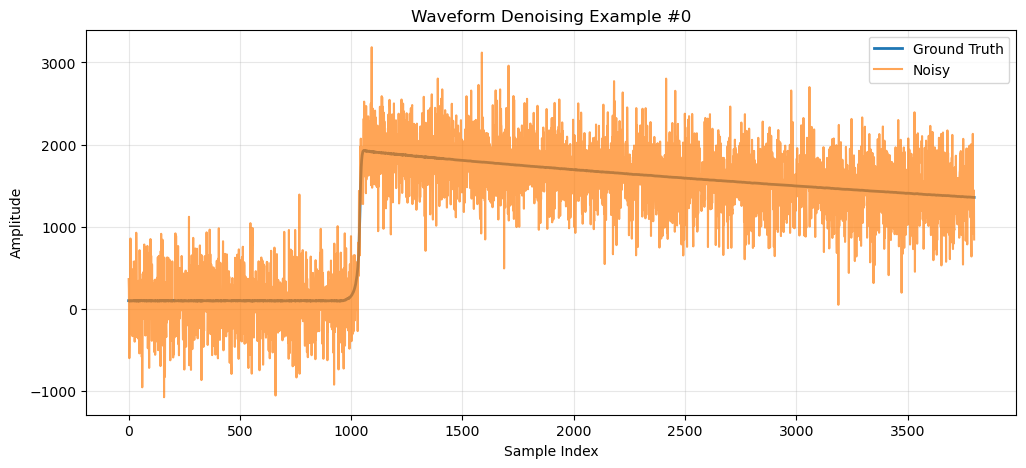

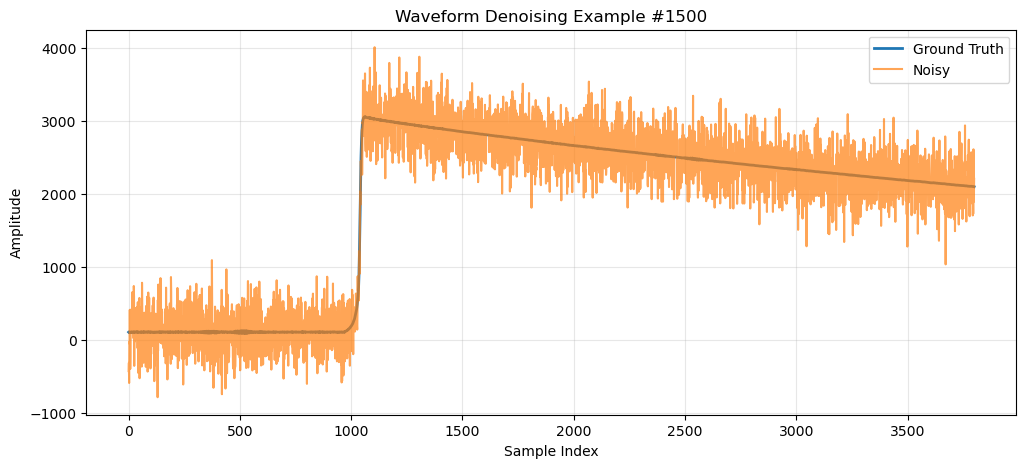

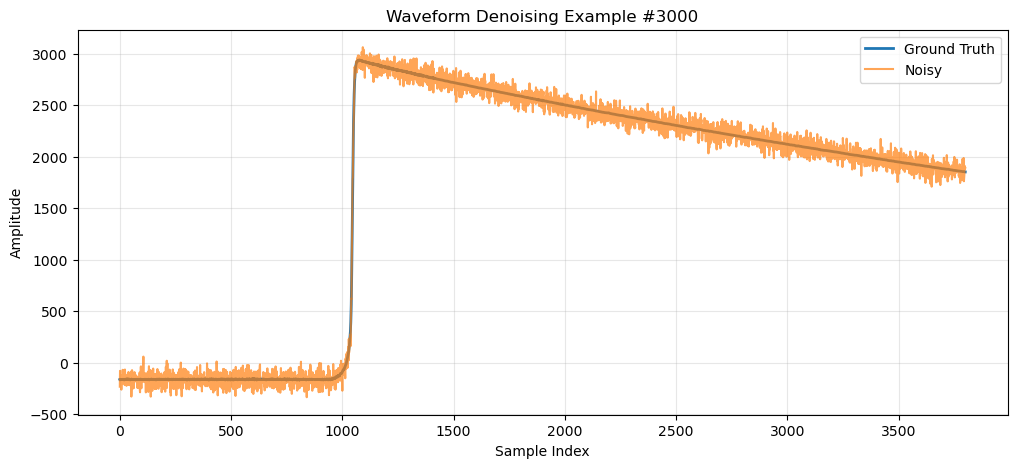

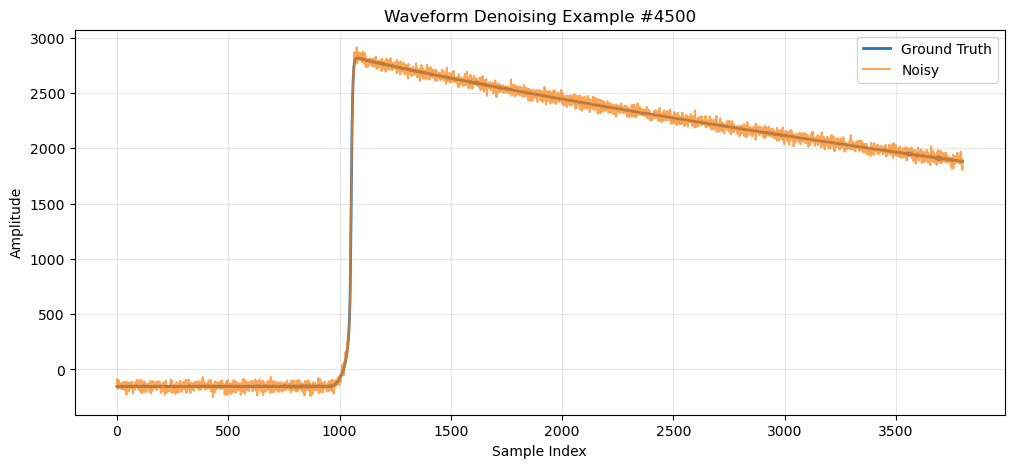

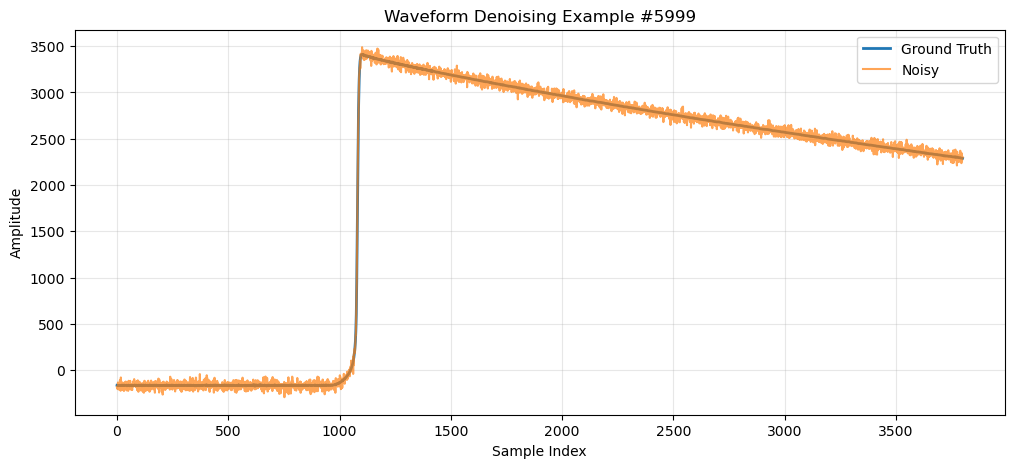

In [10]:
for i in [0, 1500, 3000, 4500, 5999]:
    gt = clean_shifted[i]
    nw = noisy[i]
    plt.figure(figsize=(12,5))

    plt.plot(gt, label="Ground Truth", linewidth=2)
    plt.plot(nw, label="Noisy", alpha=0.7)
    plt.title(f"Waveform Denoising Example #{i}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [11]:
clean_cnn = clean_shifted[..., np.newaxis]      # (N, L, 1)
noisy_cnn = noisy[..., np.newaxis]

print("CNN-ready shape:", noisy_cnn.shape)

CNN-ready shape: (6000, 3800, 1)


In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    noisy_cnn, clean_cnn, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (4200, 3800, 1)
Val: (900, 3800, 1)
Test: (900, 3800, 1)


# Building the CNN model for training

In [13]:
import keras

from keras import Input

from keras.models import Sequential #the model is built adding layers one after the other

from keras.layers import Dense #fully connected layers: every output talks to every input

from keras.layers import Flatten #for flattening tensor data

from keras.layers import Activation

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, UpSampling1D, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import AdamW

In [14]:
optimizer = AdamW(learning_rate=3e-5, weight_decay=0.000008)

L = clean.shape[1]

model_2 = Sequential()

# ---- Encoder ----
model_2.add(layers.Input(shape=(L,1)))

model_2.add(Conv1D(16, 9, padding='same', activation='relu'))
model_2.add(AveragePooling1D(pool_size=5))

model_2.add(Conv1D(32, 9, padding='same', activation='relu'))
model_2.add(AveragePooling1D(pool_size=5))

# ---- Bottleneck ----
model_2.add(Conv1D(64, 9, padding='same', activation='relu'))
model_2.add(Conv1D(128, 9, padding='same', activation='relu'))

# ---- Decoder ----
model_2.add(UpSampling1D(size=5))
model_2.add(Conv1D(32, 9, padding='same', activation='relu'))
model_2.add(UpSampling1D(size=5))
model_2.add(Conv1D(16, 9, padding='same', activation='relu'))

# Final layer → output same shape as original waveform
model_2.add(Conv1D(1, 9, padding='same', activation='linear'))

model_2.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mae']
)

model_2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3800, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 760, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 760, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 152, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 152, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 152, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 760, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 760, 32)        │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 3800, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3800, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 3800, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,817 (542.25 KB)

 Trainable params: 138,817 (542.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
mynet = model_2.fit(X_train, y_train, epochs=40, batch_size=32, 
                    validation_data=(X_val, y_val), shuffle=True,
                    callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_delta=0.1, verbose=1, min_lr=1e-7),
                                 keras.callbacks.EarlyStopping(patience=8, min_delta=.01, verbose=1)])

Epoch 1/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 829.0313 - mae: 829.5303 - val_loss: 70.0643 - val_mae: 70.5615 - learning_rate: 3.0000e-05
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 43.6410 - mae: 44.1252 - val_loss: 28.9144 - val_mae: 29.3947 - learning_rate: 3.0000e-05
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - loss: 22.7526 - mae: 23.2376 - val_loss: 17.7972 - val_mae: 18.2750 - learning_rate: 3.0000e-05
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - loss: 15.7080 - mae: 16.1904 - val_loss: 14.6321 - val_mae: 15.1146 - learning_rate: 3.0000e-05
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - loss: 13.6837 - mae: 14.1652 - val_loss: 14.4212 - val_mae: 14.9109 - learning_rate: 3.0000e-05
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 12.7418 - mae: 13.2235 - val_loss: 12.7596 - val_mae: 13.2444 - learning_rate: 3.0000e-05
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 12.1508 - mae: 12.6328

In [16]:
denoised = model_2.predict(noisy[..., None])


188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


## Learning Curve

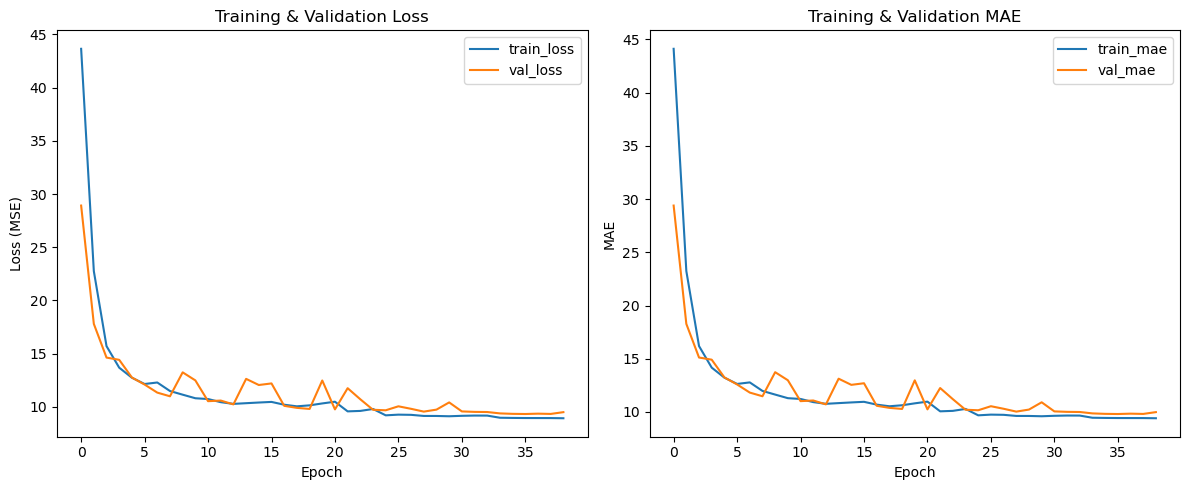

In [17]:
# ---- Learning Curves ----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(mynet.history["loss"][1:], label="train_loss")
plt.plot(mynet.history["val_loss"][1:], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(mynet.history["mae"][1:], label="train_mae")
plt.plot(mynet.history["val_mae"][1:], label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training & Validation MAE")
plt.legend()

plt.tight_layout()
plt.show()

## Comparison of Ground Truth, Noisy, and Denoised Waveforms

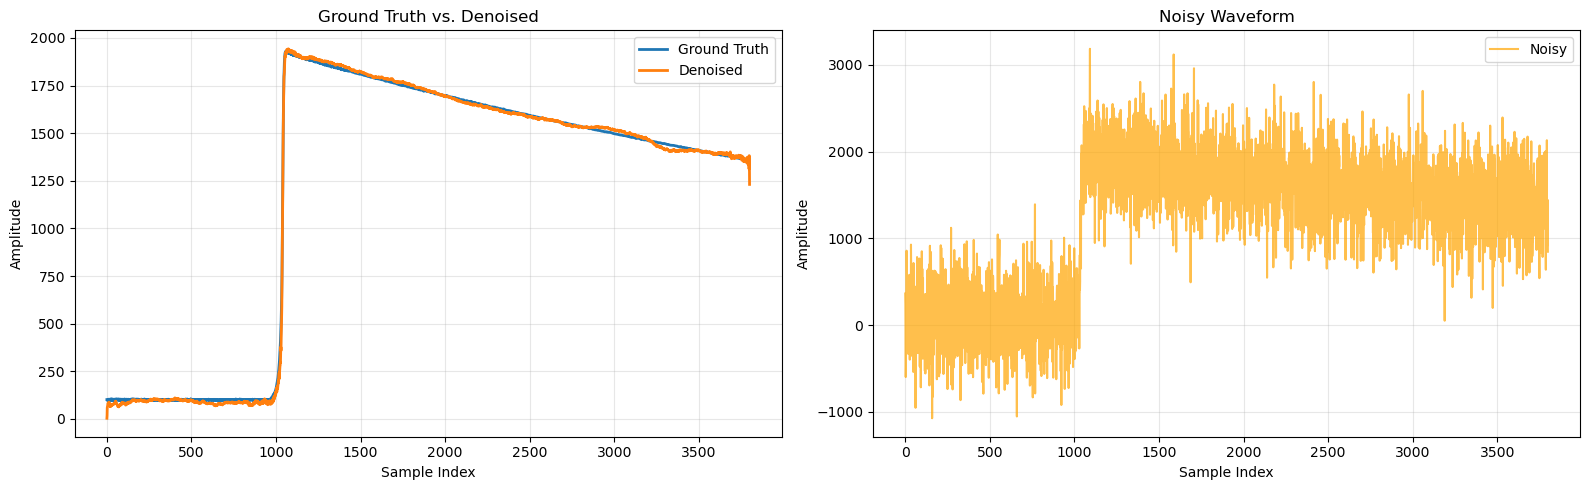

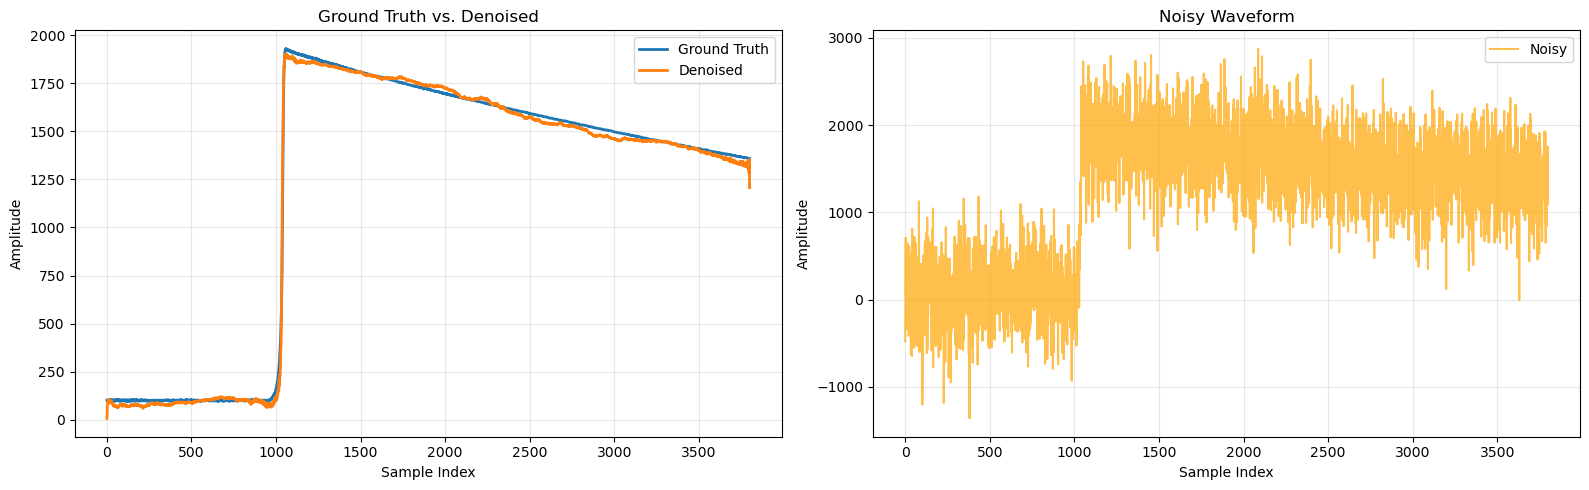

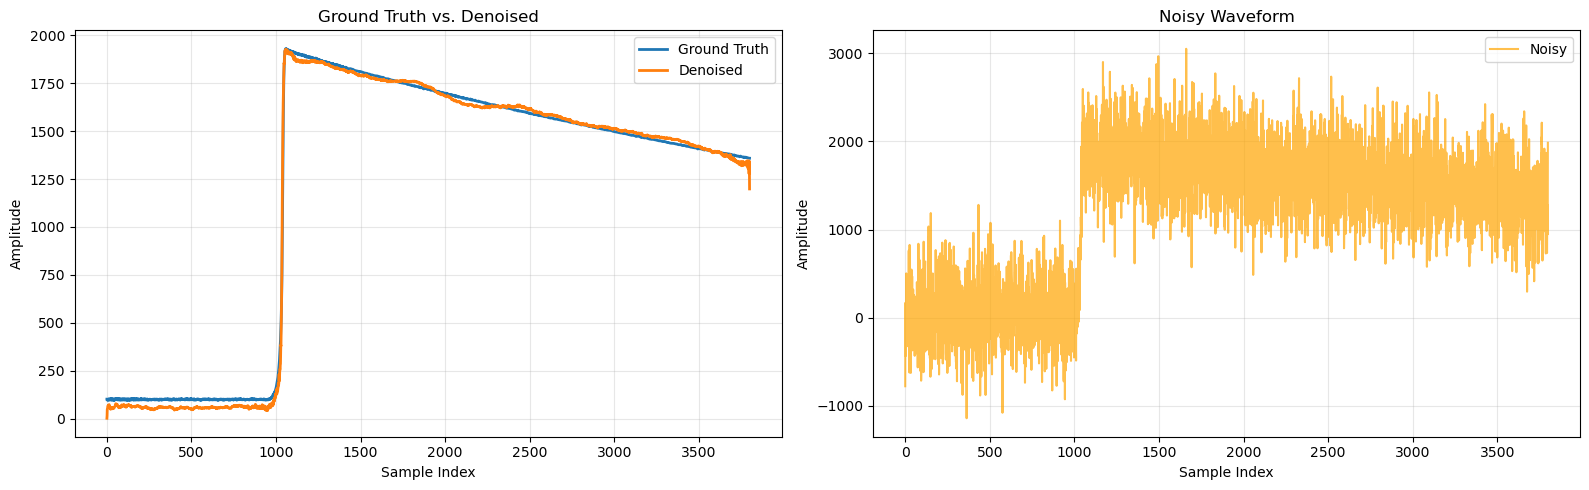

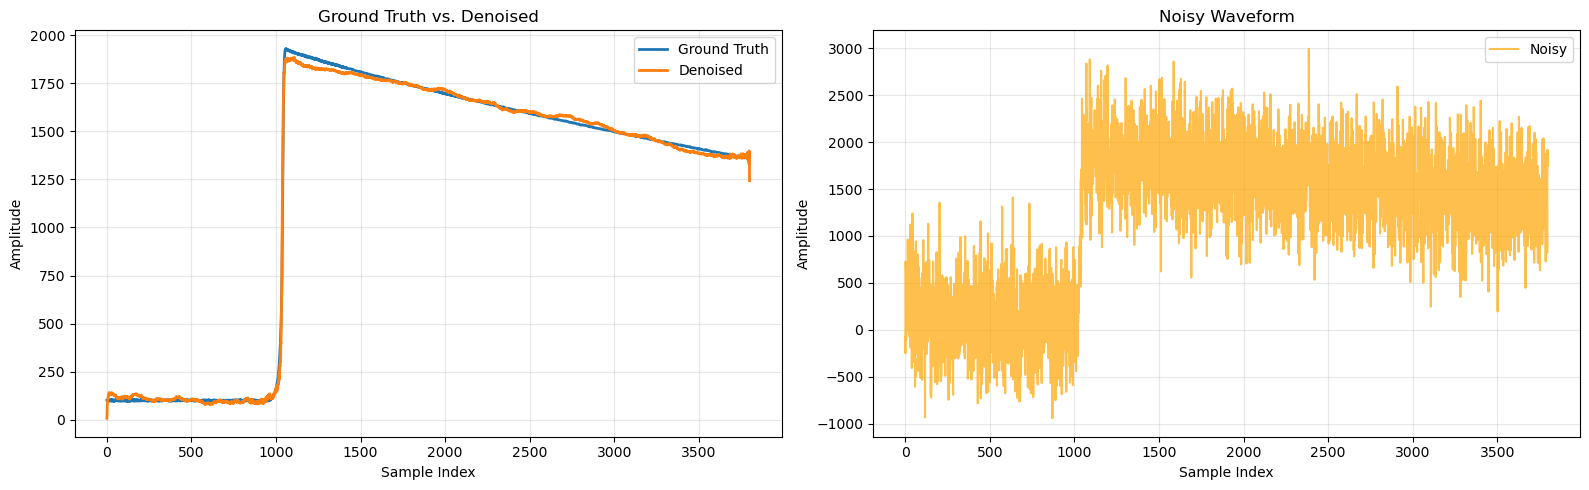

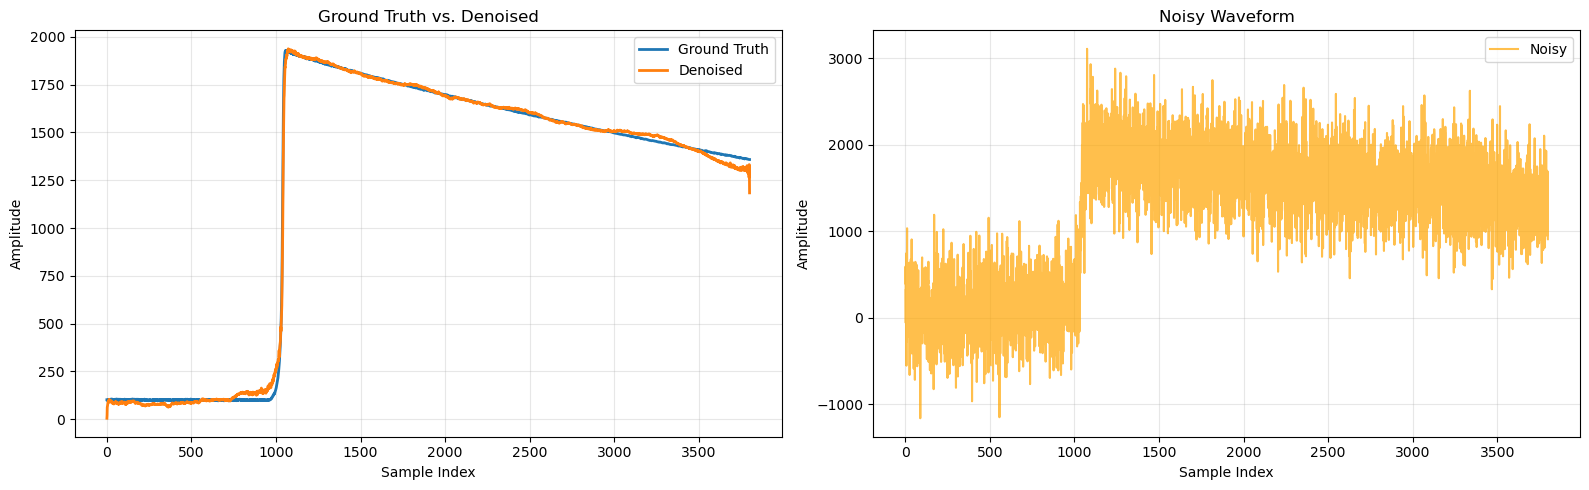

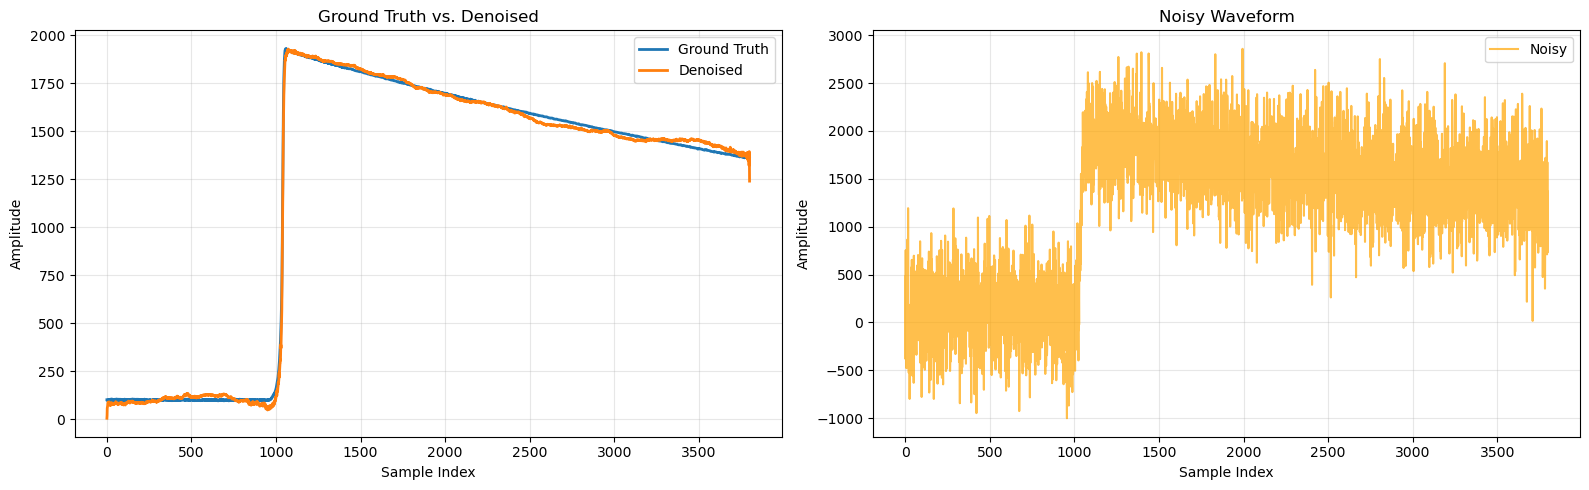

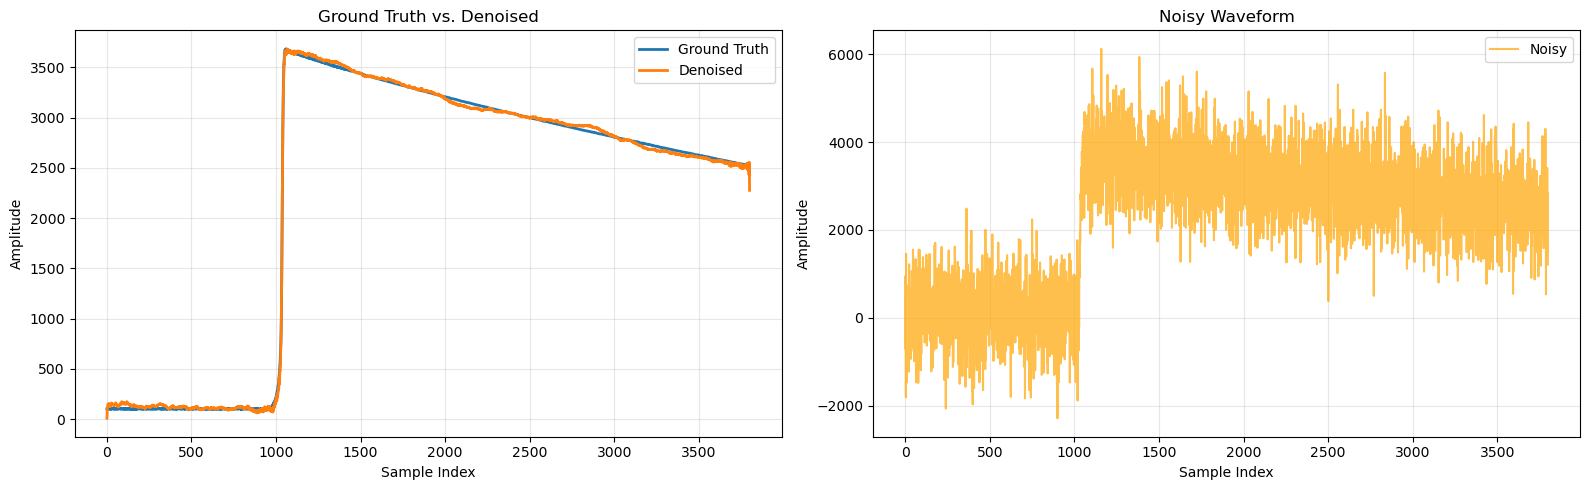

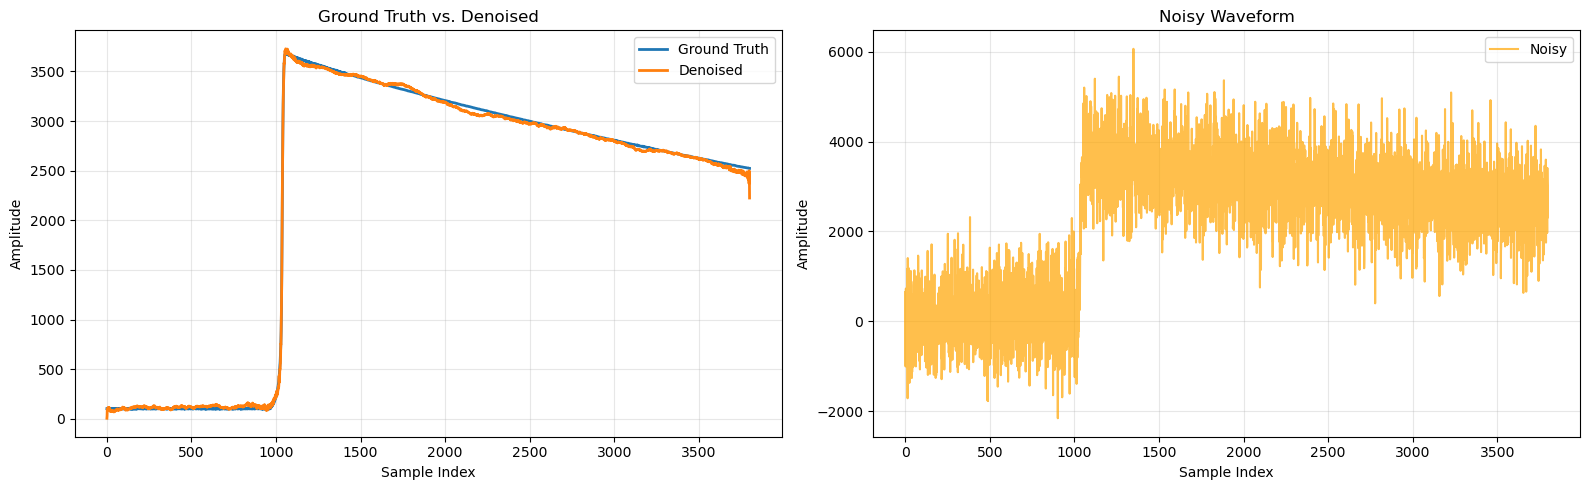

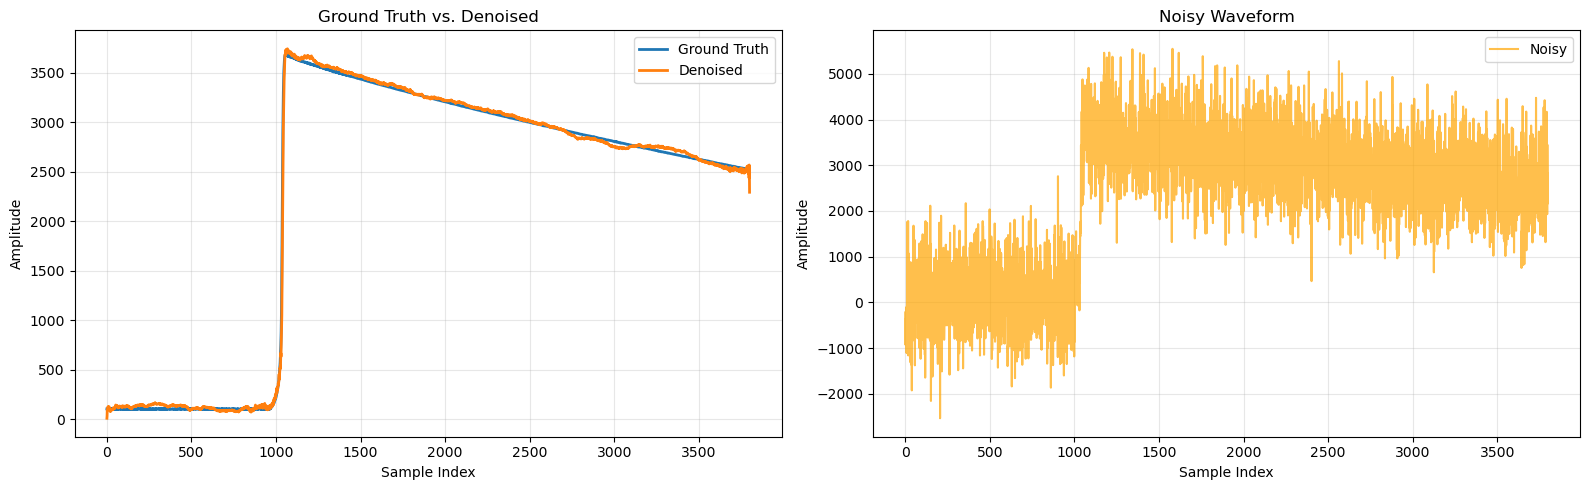

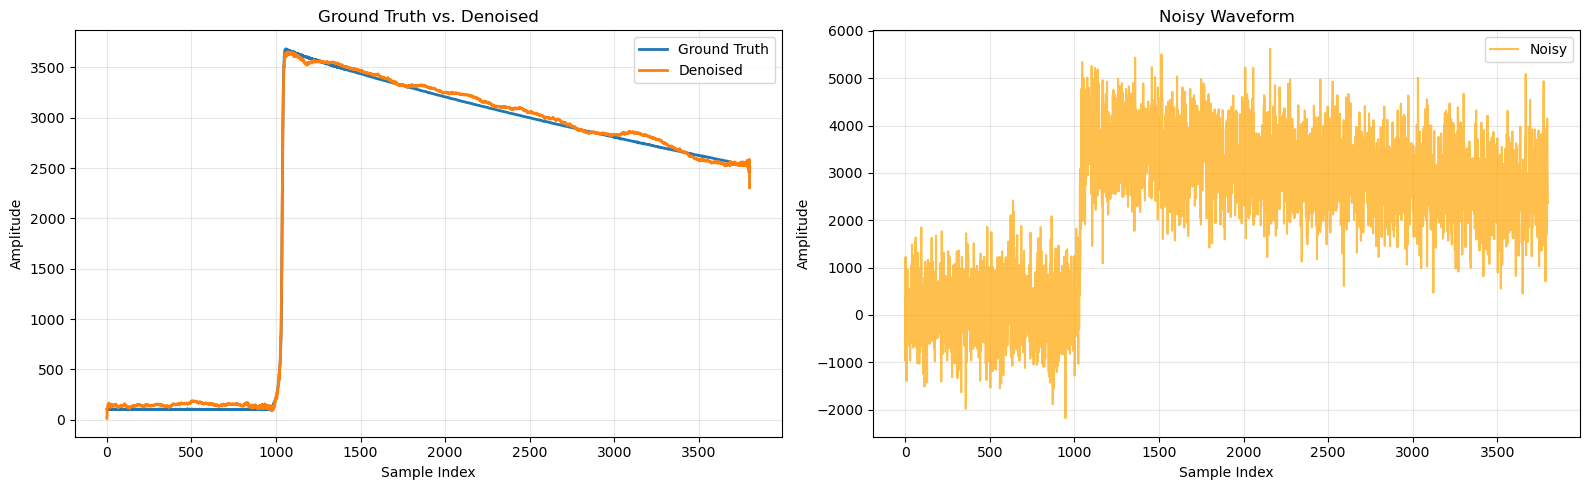

In [18]:
for i in range(10):
    gt = clean_shifted[i]
    nw = noisy[i]
    dn = denoised[i].squeeze()   # handles (L,) or (L,1)

    fig, axs = plt.subplots(1, 2, figsize=(16,5))  # 1 row, 2 columns

    # Left plot: Ground Truth vs Denoised
    axs[0].plot(gt, label="Ground Truth", linewidth=2)
    axs[0].plot(dn, label="Denoised", linewidth=2)
    axs[0].set_title(f"Ground Truth vs. Denoised")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Amplitude")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Right plot: Noisy waveform
    axs[1].plot(nw, label="Noisy", alpha=0.7, color='orange')
    axs[1].set_title(f"Noisy Waveform")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [19]:
def compute_snr(wf_clean, wf_denoised, baseline_region):
    """
    Computes SNR of the denoised waveform using the same definition
    as the SNR used to generate noisy waveforms.
    
    SNR = RMS(signal) / RMS(noise)
    
    where noise is computed only from the baseline region.
    """
    # True clean waveform (used to define the signal level)
    signal_rms = np.sqrt(np.mean(wf_clean**2))

    # Noise difference between clean and denoised
    noise = wf_denoised[baseline_region] - wf_clean[baseline_region]
    noise_rms = np.sqrt(np.mean(noise**2))

    # Avoid division by zero
    if noise_rms == 0:
        return np.inf
    
    return signal_rms / noise_rms


# ---- Compute SNR for all test waveforms ----
snr_denoised_list = []

for clean_wf, den_wf in zip(clean_shifted, denoised.squeeze()):
    snr_val = compute_snr(clean_wf, den_wf, baseline_region)
    snr_denoised_list.append(snr_val)

snr_denoised_list = np.array(snr_denoised_list)

print("Mean SNR after denoising:", np.mean(snr_denoised_list))
print("Median SNR after denoising:", np.median(snr_denoised_list))

Mean SNR after denoising: 197.76784
Median SNR after denoising: 180.7452


## Testing Denois Model on other Waveforms with various of noise.

In [20]:
SNR_target_test = 5.0   # desired SNR for the added noise 

noisy_test = []
for wf in clean_shifted:
    if method == "physics":
        n, _ = add_physics_johnson_noise(wf, kB, T, R, B, v_per_count)
    else:
        n, _ = add_target_snr_noise(
            wf, baseline_region=slice(0,1000), snr_target=SNR_target_test
        )
    noisy_test.append(n)

noisy_test = np.array(noisy_test, dtype=np.float32)
denoised_test = model_2.predict(noisy_test[..., None])

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


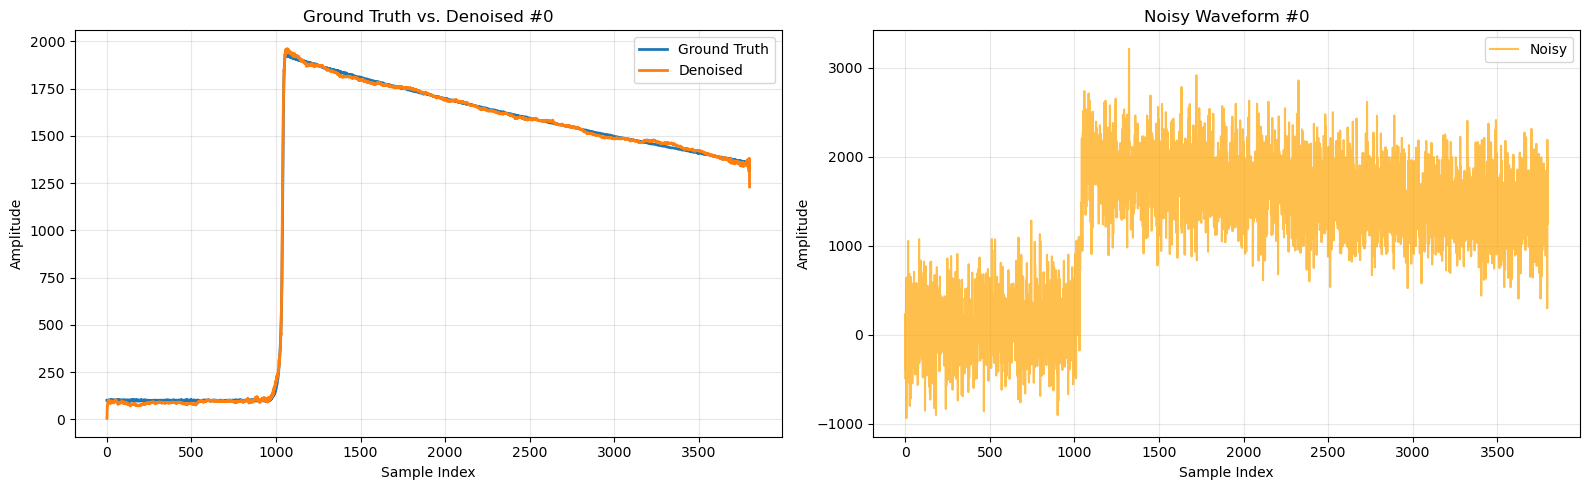

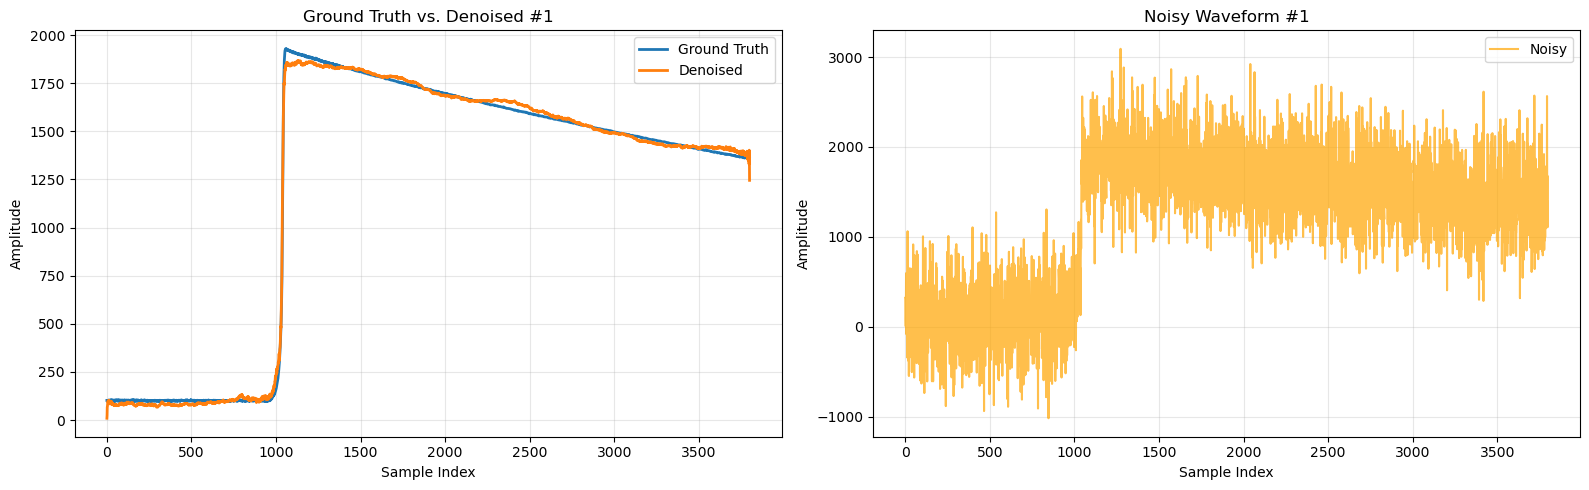

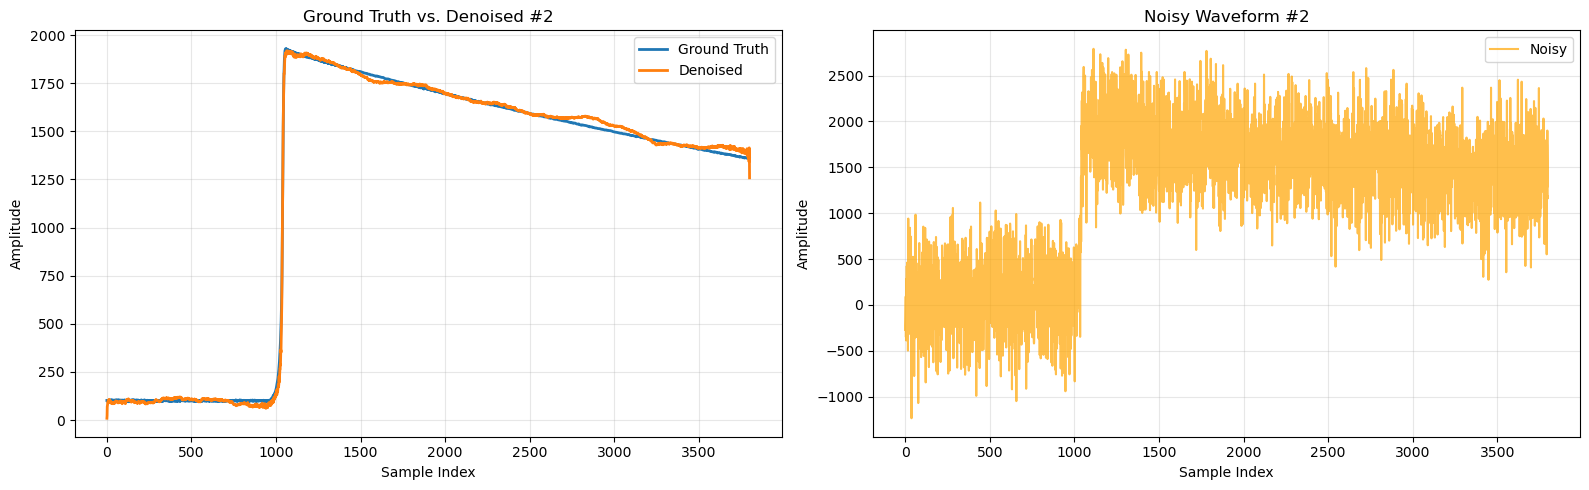

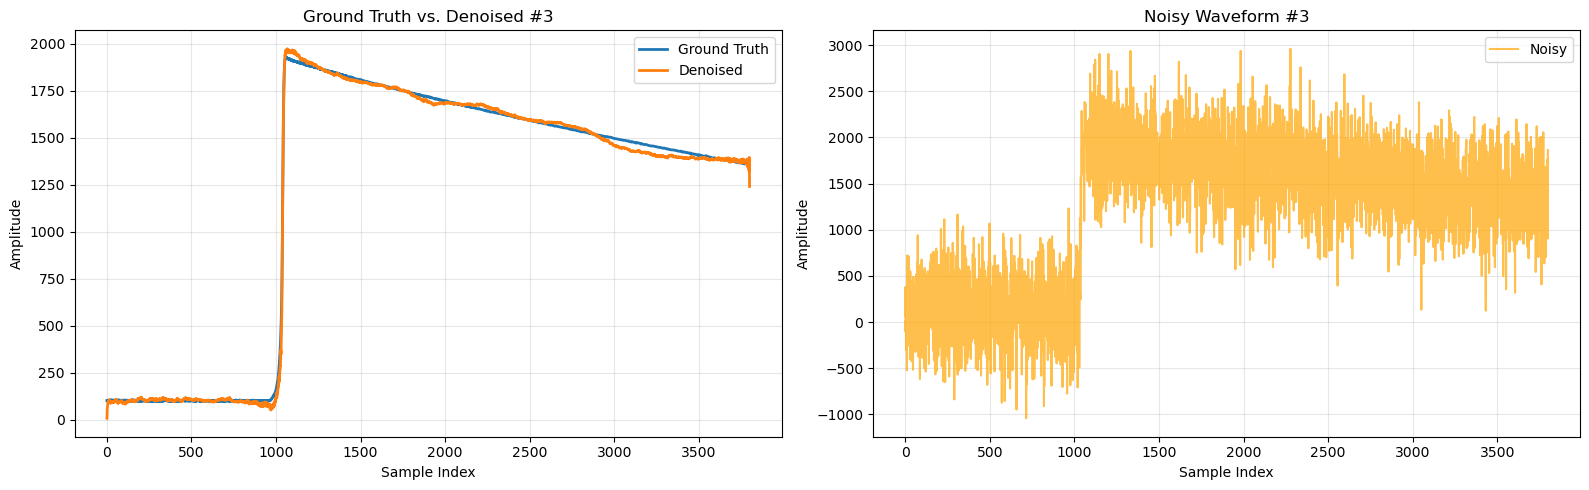

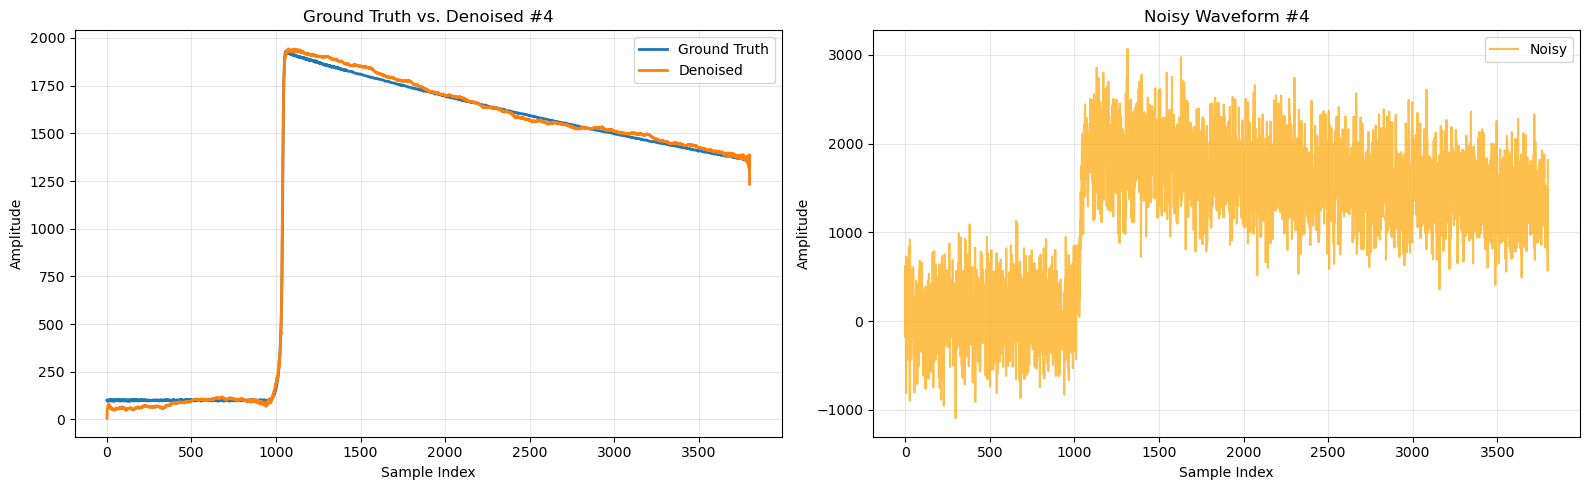

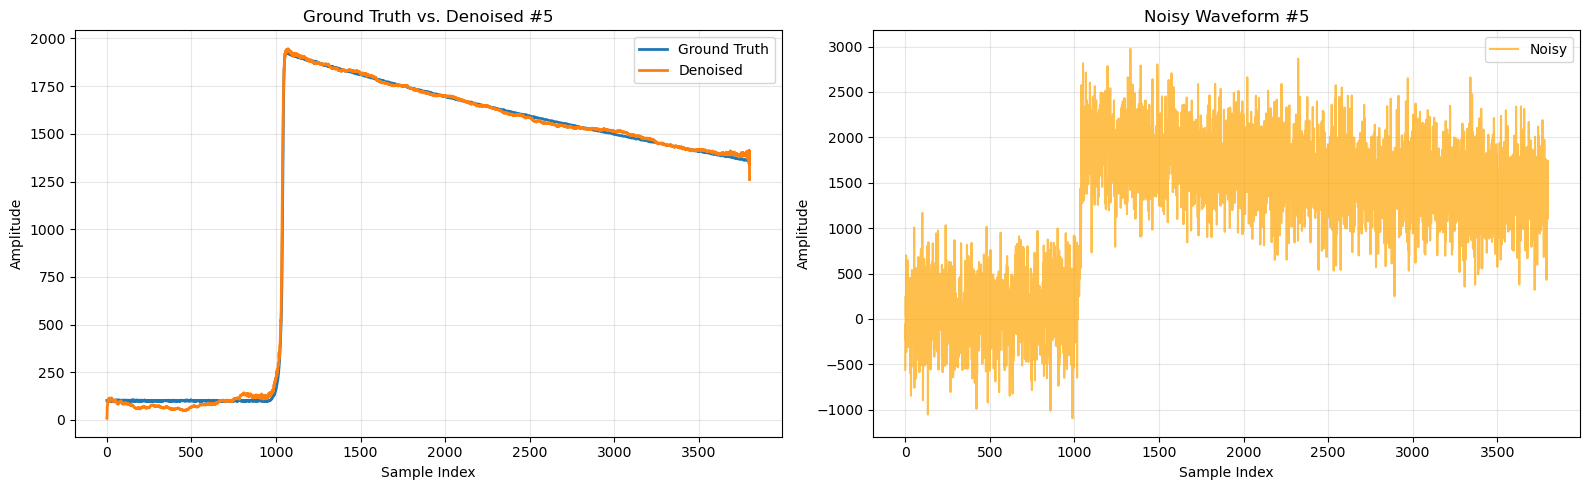

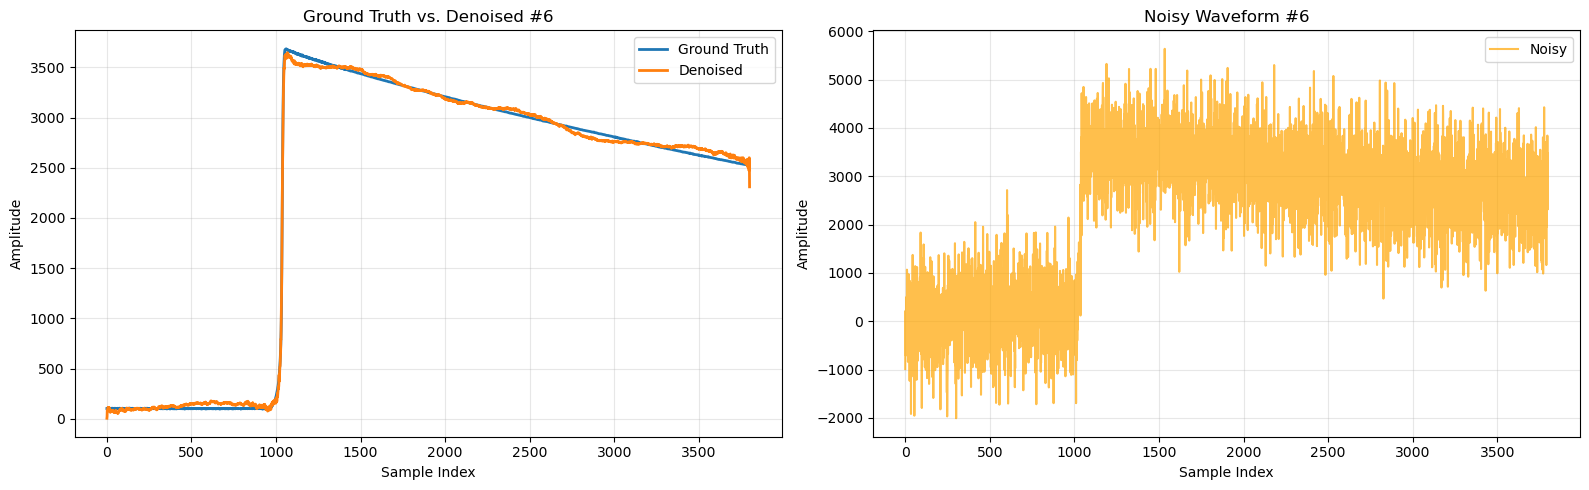

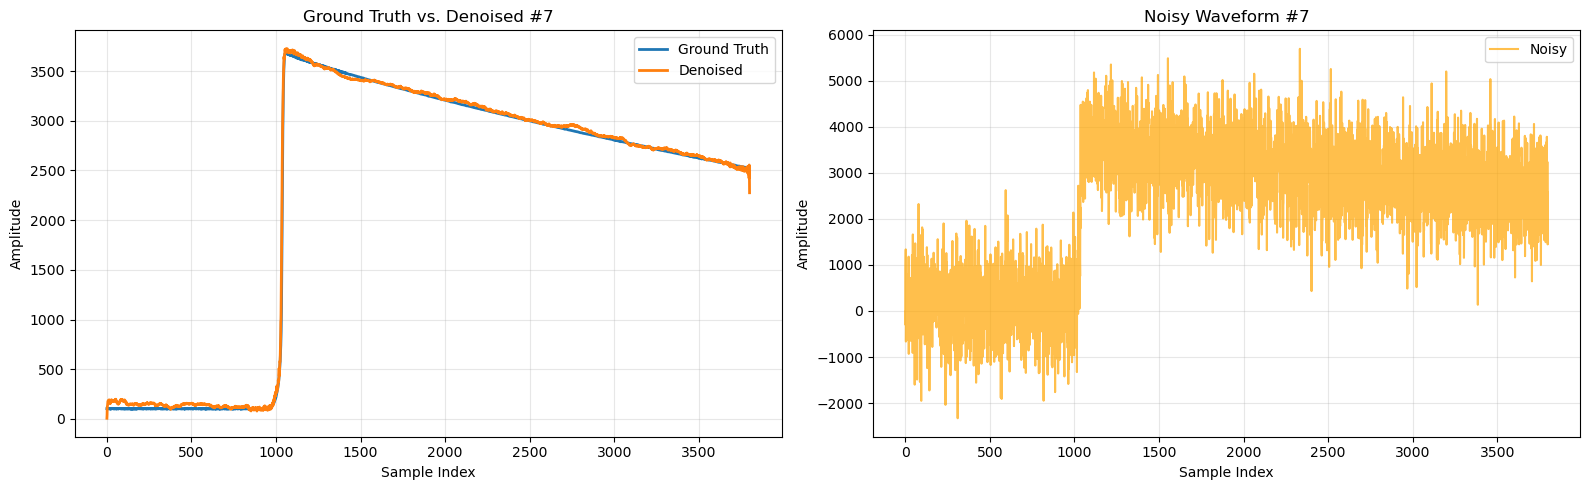

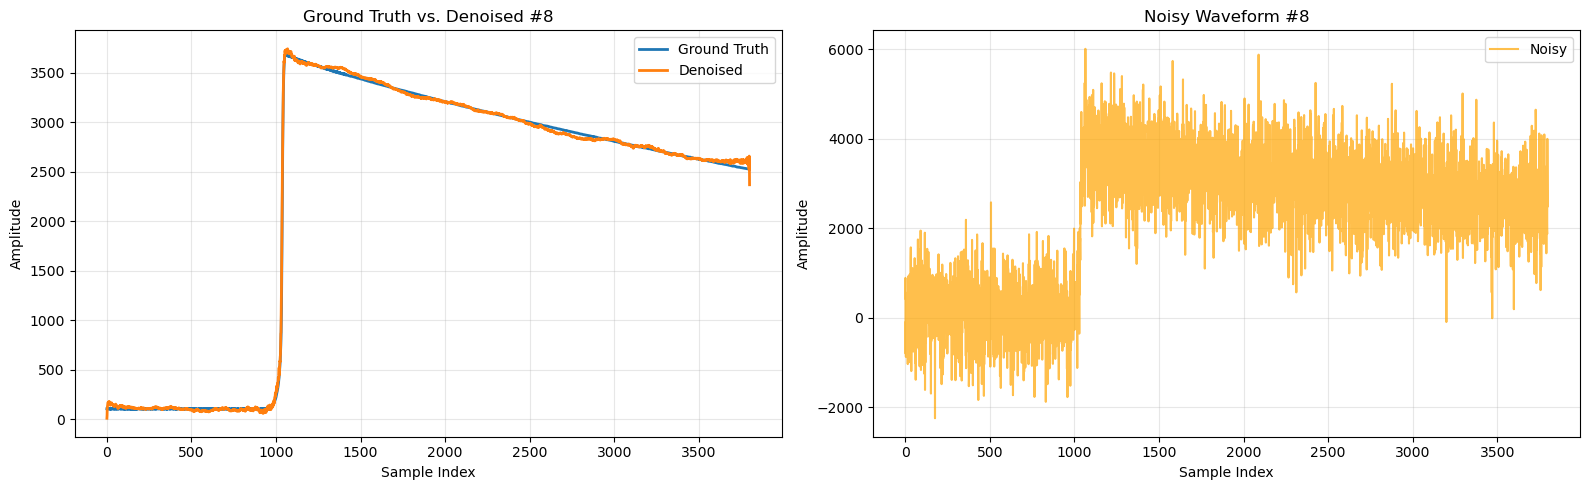

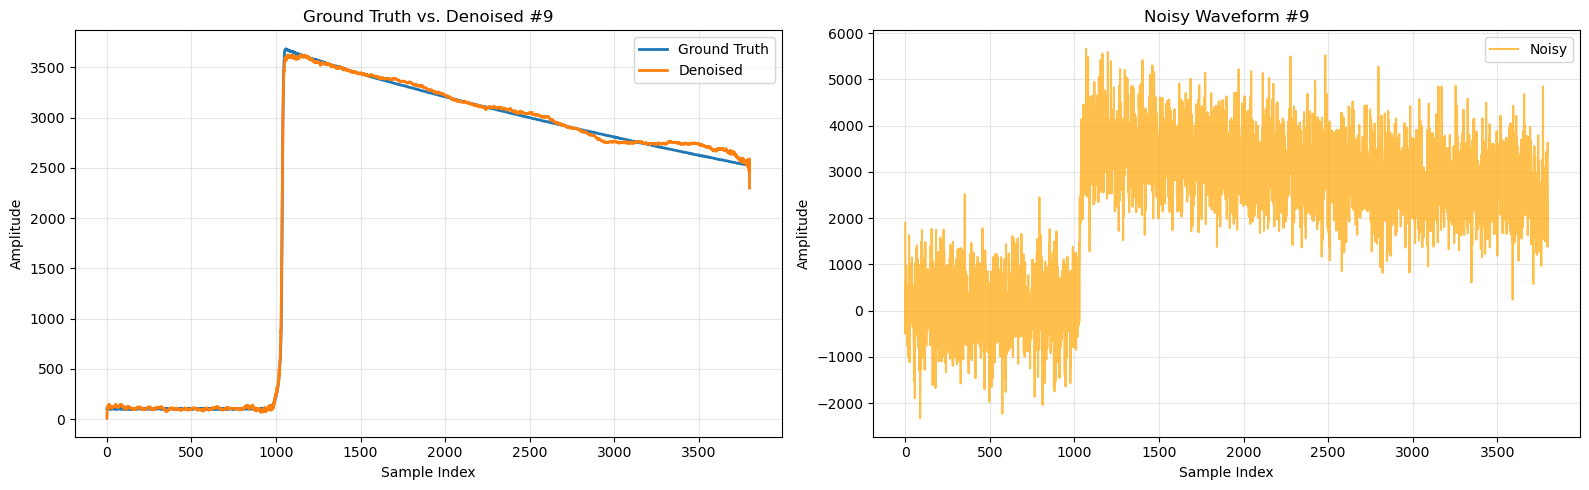

In [21]:
for i in range(10):
    gt = clean_shifted[i]
    nw = noisy_test[i]
    dn = denoised_test[i].squeeze()   # handles (L,) or (L,1)

    fig, axs = plt.subplots(1, 2, figsize=(16,5))  # 1 row, 2 columns

    # Left plot: Ground Truth vs Denoised
    axs[0].plot(gt, label="Ground Truth", linewidth=2)
    axs[0].plot(dn, label="Denoised", linewidth=2)
    axs[0].set_title(f"Ground Truth vs. Denoised #{i}")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Amplitude")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Right plot: Noisy waveform
    axs[1].plot(nw, label="Noisy", alpha=0.7, color='orange')
    axs[1].set_title(f"Noisy Waveform #{i}")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [22]:
SNR_target_200 = 200.0   # desired SNR for the added noise 

noisy_200 = []
for wf in clean_shifted:
    if method == "physics":
        n, _ = add_physics_johnson_noise(wf, kB, T, R, B, v_per_count)
    else:
        n, _ = add_target_snr_noise(
            wf, baseline_region=slice(0,1000), snr_target=SNR_target_200
        )
    noisy_200.append(n)

noisy_200 = np.array(noisy_200, dtype=np.float32)
denoised_200 = model_2.predict(noisy_200[..., None])

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


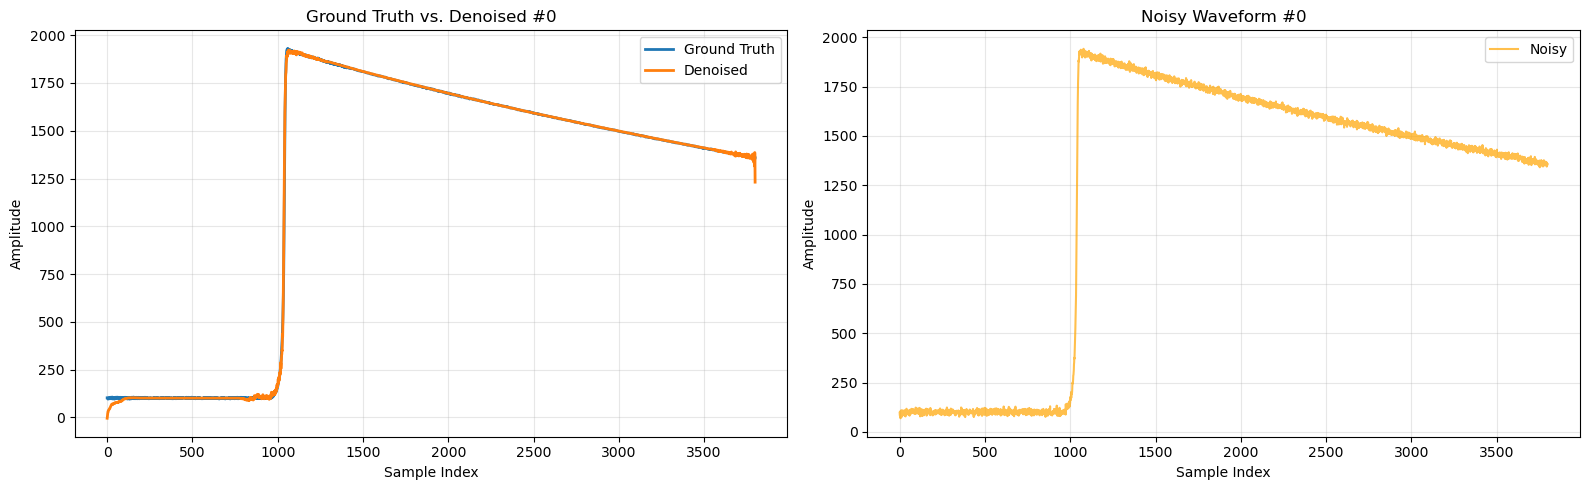

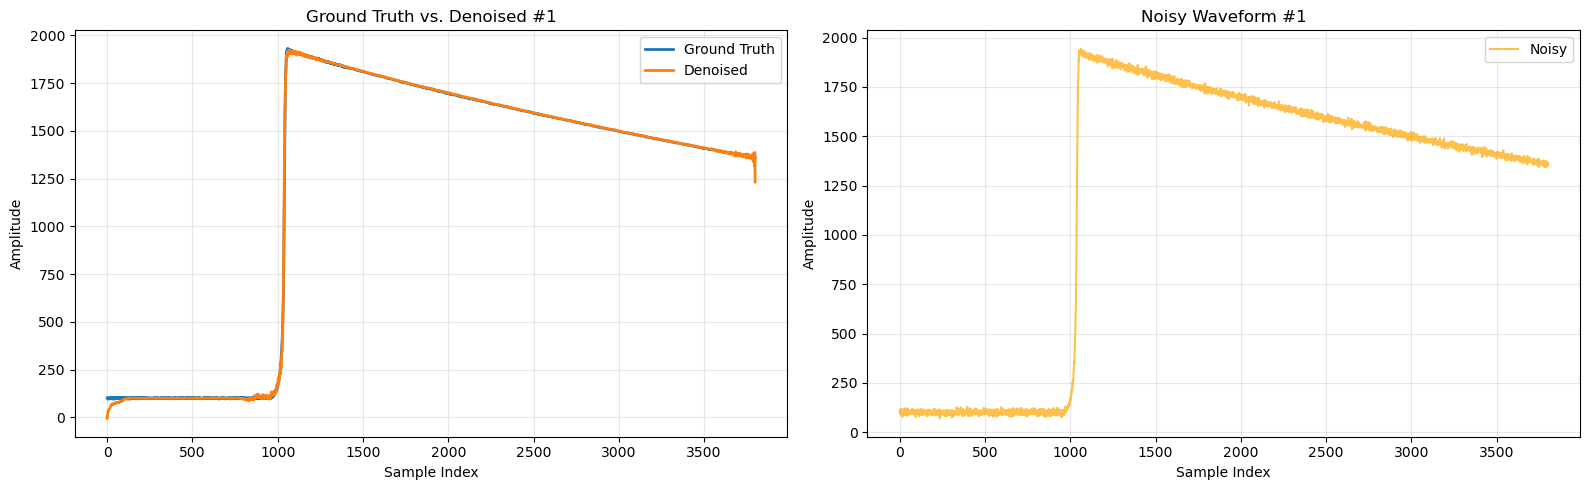

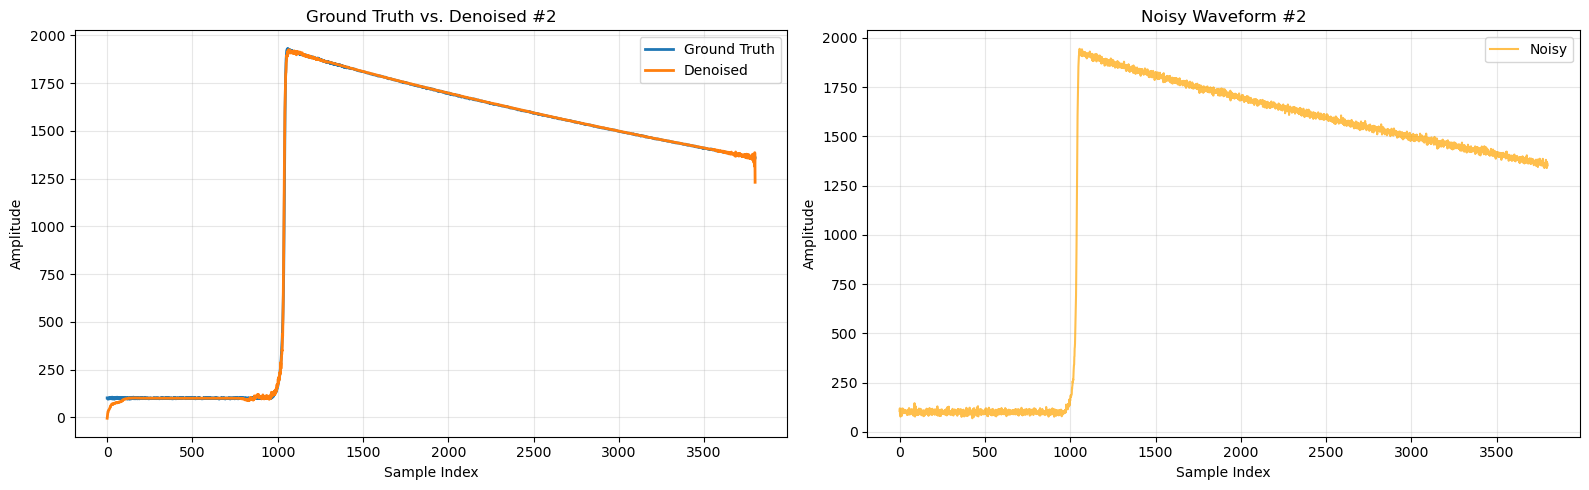

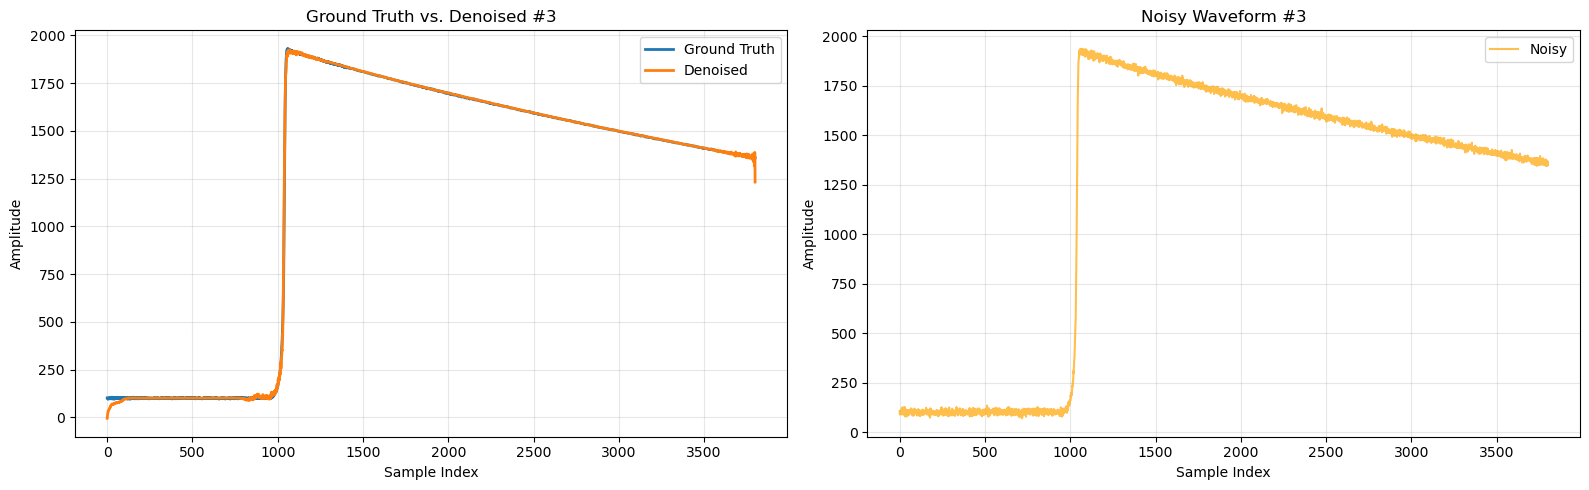

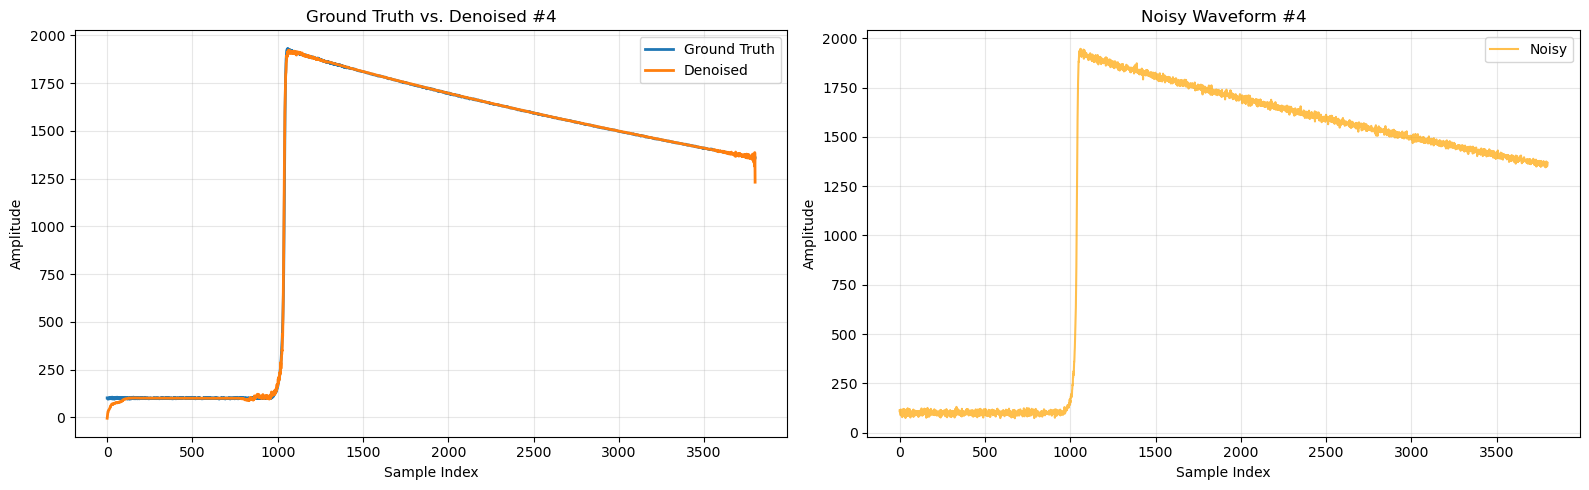

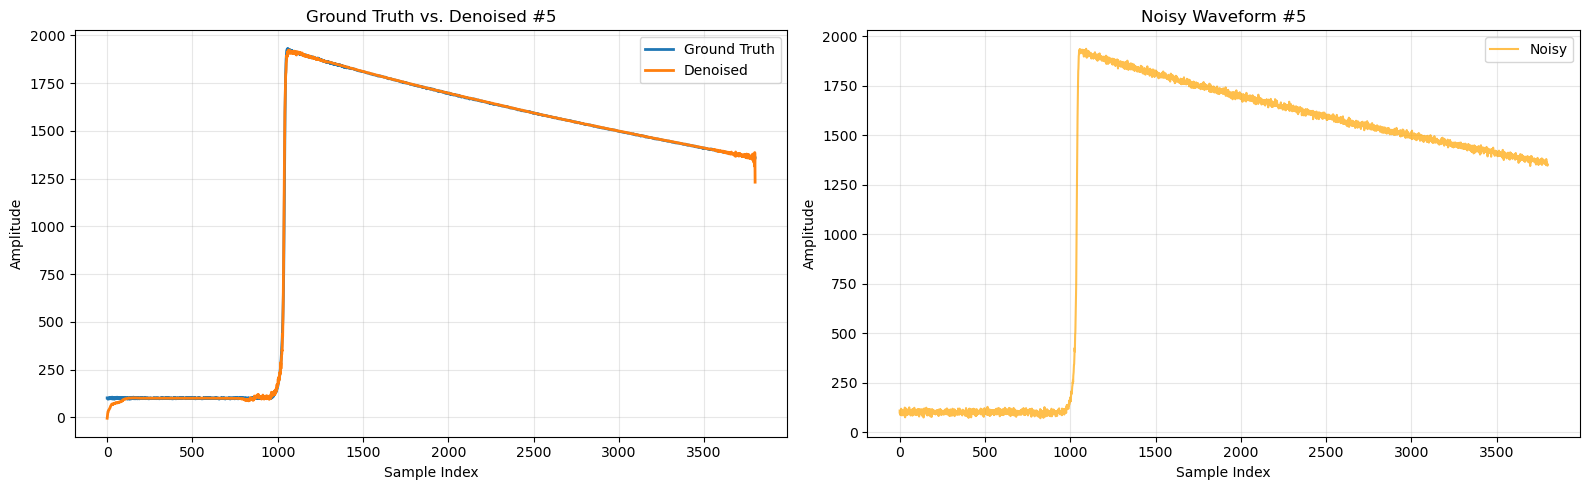

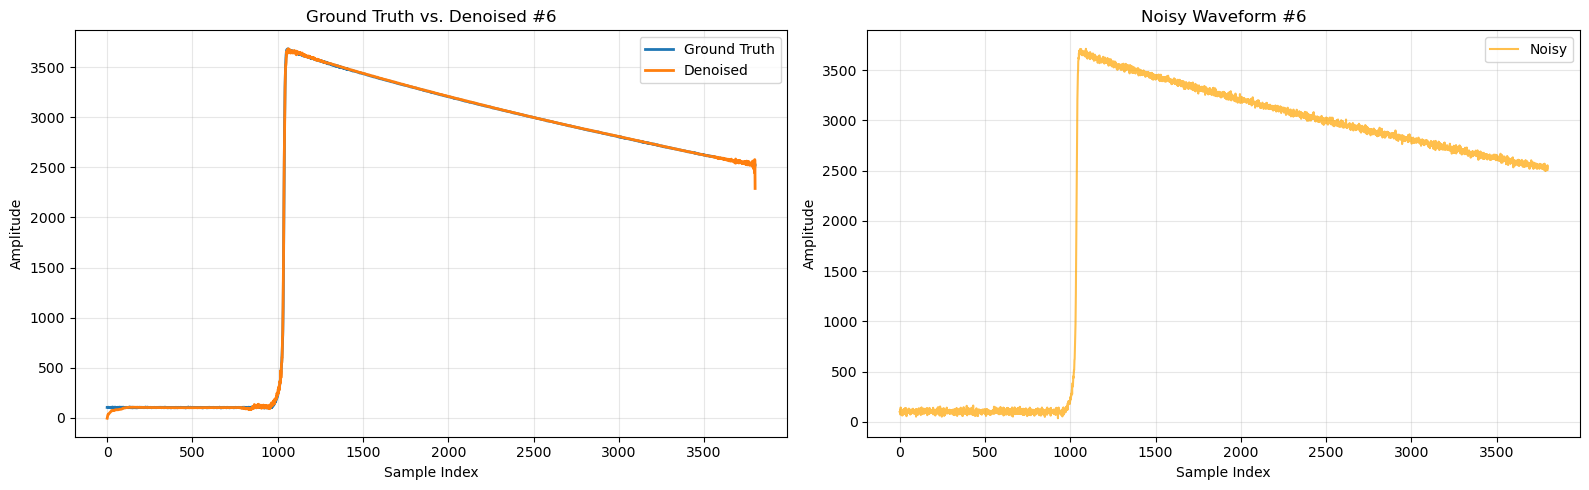

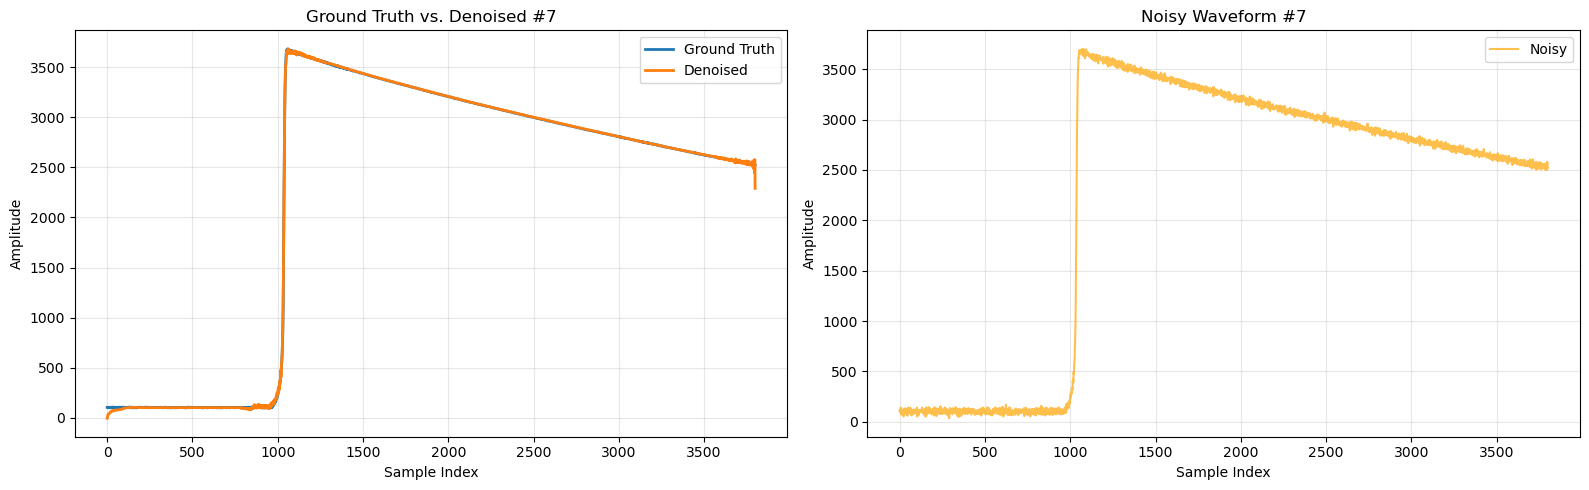

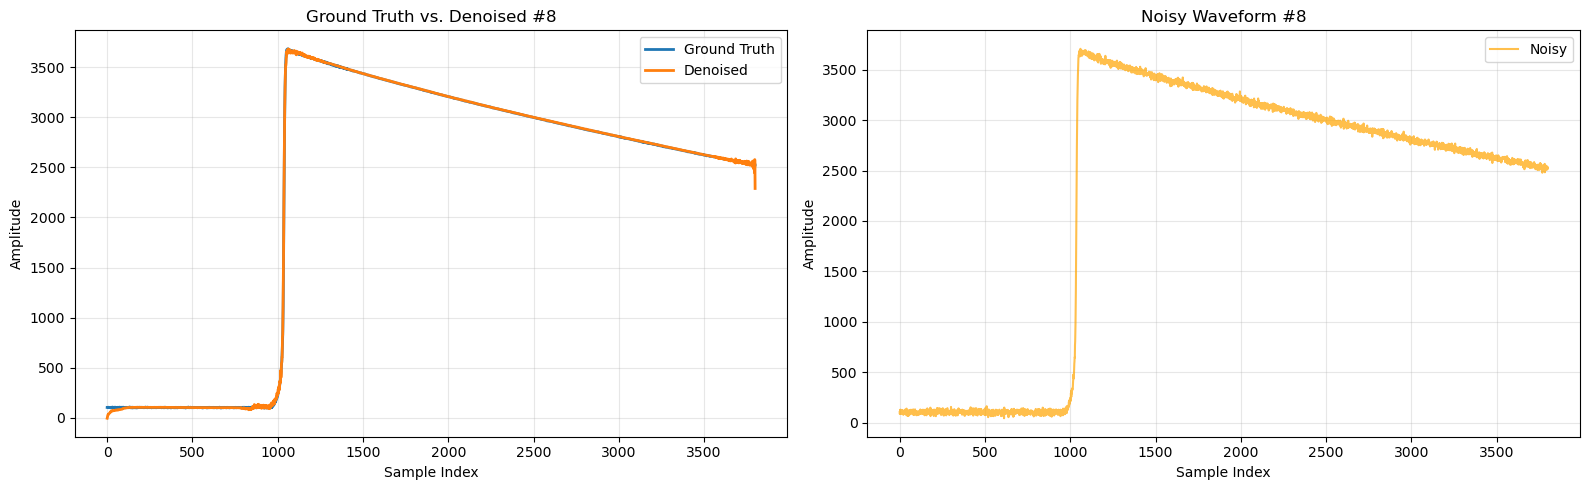

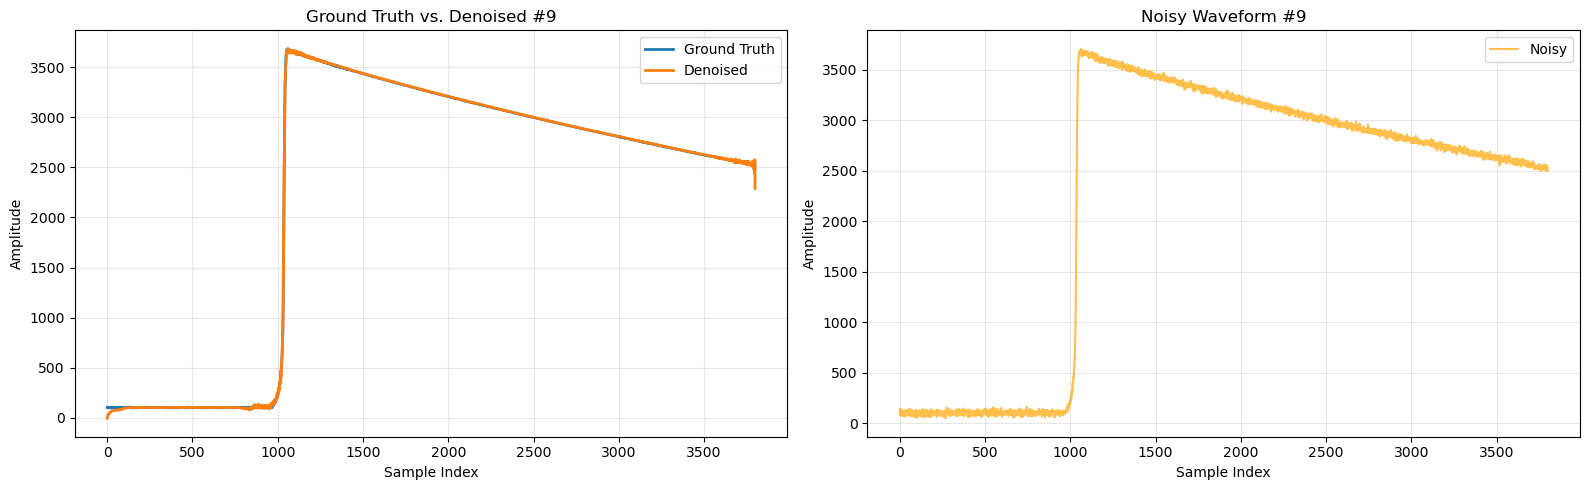

In [23]:
for i in range(10):
    gt = clean_shifted[i]
    nw = noisy_200[i]
    dn = denoised_200[i].squeeze()   # handles (L,) or (L,1)

    fig, axs = plt.subplots(1, 2, figsize=(16,5))  # 1 row, 2 columns

    # Left plot: Ground Truth vs Denoised
    axs[0].plot(gt, label="Ground Truth", linewidth=2)
    axs[0].plot(dn, label="Denoised", linewidth=2)
    axs[0].set_title(f"Ground Truth vs. Denoised #{i}")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Amplitude")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Right plot: Noisy waveform
    axs[1].plot(nw, label="Noisy", alpha=0.7, color='orange')
    axs[1].set_title(f"Noisy Waveform #{i}")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## Output of the Bottle Neck layer

In [24]:
from tensorflow.keras import Input, Model
lol = model_2(X_train[:1])

# pick your bottleneck layer:
# layers: 0 Input, 1 Conv16, 2 Pool, 3 Conv32, 4 Pool, 5 Conv64, 6 Conv128
bottleneck_layer_index = 5

bottleneck_model = Model(
    inputs=model_2.layers[0].input,
    outputs=model_2.layers[bottleneck_layer_index].output
)
bottleneck_features = bottleneck_model.predict(noisy[..., None])

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


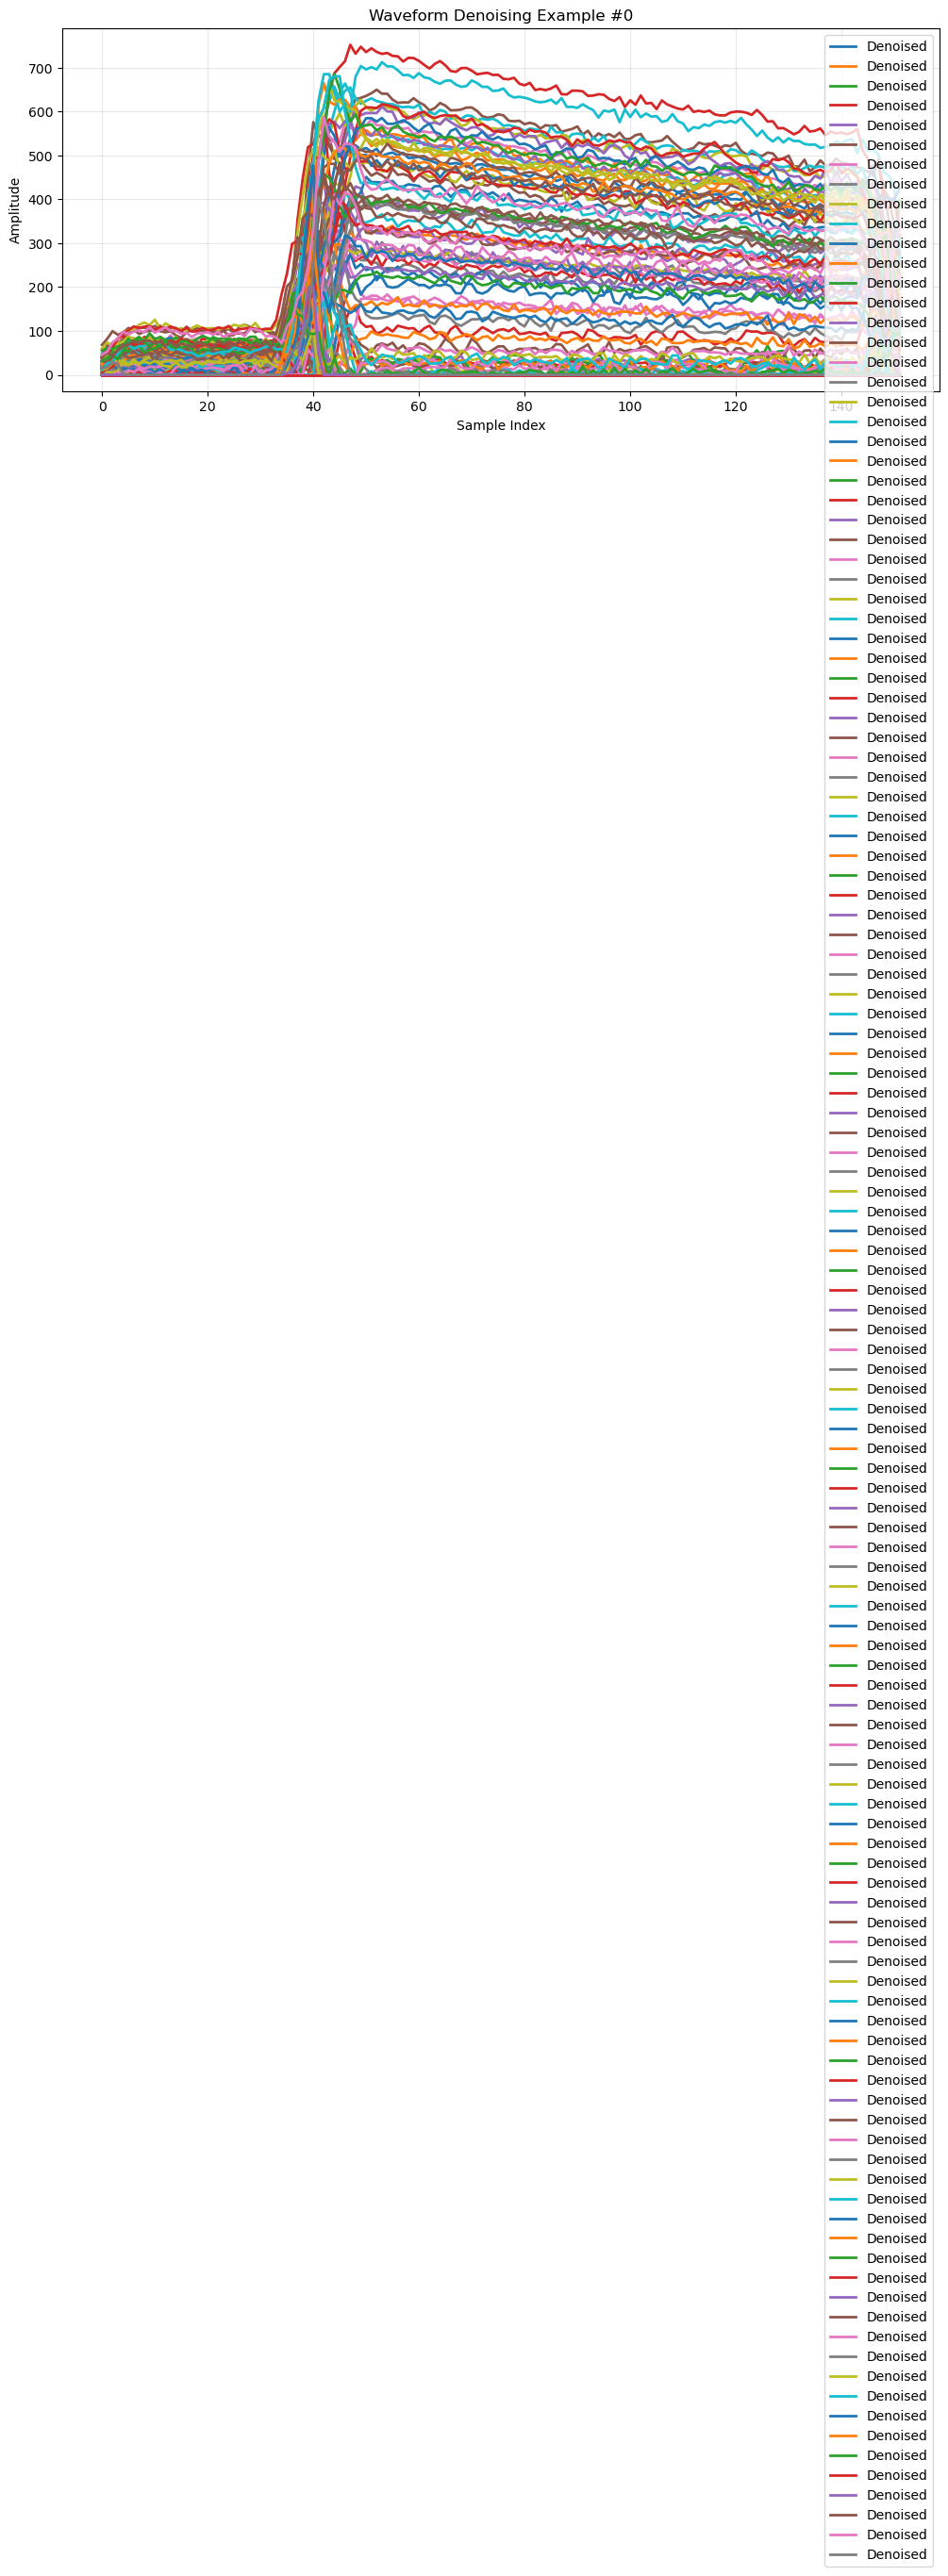

In [25]:
i = 0
gt = clean[i]
nw = noisy[i]
dn = bottleneck_features[i].squeeze()   # handles (L,) or (L,1)
plt.figure(figsize=(12,5))

# plt.plot(gt, label="Ground Truth", linewidth=2)
# plt.plot(nw, label="Noisy", alpha=0.7)
plt.plot(dn, label="Denoised", linewidth=2)
plt.title(f"Waveform Denoising Example #{i}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Testing model on Poisson Noise

Keys: ['detector', 'energy_label', 'id', 'psd_label_dcr', 'psd_label_high_avse', 'psd_label_low_avse', 'psd_label_lq', 'raw_waveform', 'run_number', 'tp0']
Found 25403 selected waveforms
Selected 1000 high-SNR waveforms


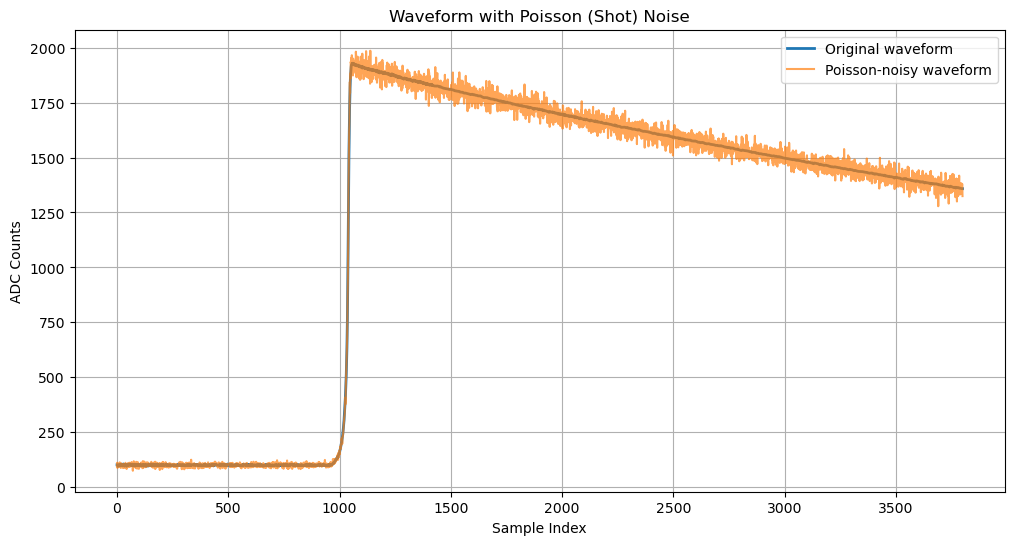

In [26]:
with h5py.File(filename, "r") as f:
    print("Keys:", list(f.keys()))
    
    waveforms = f["raw_waveform"][:]                
    sse_label = f["psd_label_low_avse"][:]
    energy_label = f["energy_label"][:]

# --------------------------------------------------------------
# 2. Select single-site events and energy range
# --------------------------------------------------------------
combined_indices = np.where(
    (sse_label == 1) &
    (energy_label >= 30) &
    (energy_label <= 1500)
)[0]

selected_waveforms = waveforms[combined_indices]
selected_energies = energy_label[combined_indices]

print(f"Found {len(selected_waveforms)} selected waveforms")

# --------------------------------------------------------------
# 3. Compute SNR to pick high-SNR waveforms
# --------------------------------------------------------------
baseline_region = slice(0, 1000)
snr_list = []

for wf in selected_waveforms:
    baseline = wf[baseline_region]
    baseline_mean = np.mean(baseline)
    baseline_std = np.std(baseline)
    amplitude = np.max(wf) - baseline_mean
    snr = 20 * np.log10(amplitude / baseline_std) if baseline_std > 0 else np.nan
    snr_list.append(snr)

snr_list = np.array(snr_list)
sorted_indices = np.argsort(snr_list)
high_snr_indices = sorted_indices[-1000:]  # top 1000 waveforms
high_waveforms = selected_waveforms[high_snr_indices]

print(f"Selected {len(high_waveforms)} high-SNR waveforms")

# --------------------------------------------------------------
# 4. Poisson noise function
# --------------------------------------------------------------
def add_poisson_noise(wf, scale=100.0):
    """
    Adds Poisson (shot) noise to a waveform.
    Converts waveform to positive domain, applies Poisson noise,
    and shifts back.
    """
    wf = np.asarray(wf, dtype=np.float32)

    # Shift waveform to be >= 0
    min_val = np.min(wf)
    shift = -min_val if min_val < 0 else 0.0
    wf_pos = wf + shift

    # Convert to "counts"
    wf_counts = wf_pos / scale

    # Apply Poisson noise
    noisy_counts = np.random.poisson(wf_counts)

    # Convert back
    noisy_wf = noisy_counts * scale

    # Shift back to original baseline
    noisy_wf -= shift

    return noisy_wf

# --------------------------------------------------------------
# 5. Pick a waveform → add Poisson noise → plot
# --------------------------------------------------------------
index = 0  # choose which waveform to display
wf = high_waveforms[index]

noisy_wf = add_poisson_noise(wf, scale=0.5)

# --------------------------------------------------------------
# 6. Plot original and noisy waveforms
# --------------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(wf, label="Original waveform", linewidth=2)
plt.plot(noisy_wf, label="Poisson-noisy waveform", alpha=0.7)
plt.title("Waveform with Poisson (Shot) Noise")
plt.xlabel("Sample Index")
plt.ylabel("ADC Counts")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
poisson_wf = []
for wf in high_waveforms:
    n = add_poisson_noise(wf, scale=0.5)
    poisson_wf.append(n)
poisson_wf = np.array(poisson_wf, dtype=np.float32)
denoised_poisson = model_2.predict(poisson_wf[..., None])

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


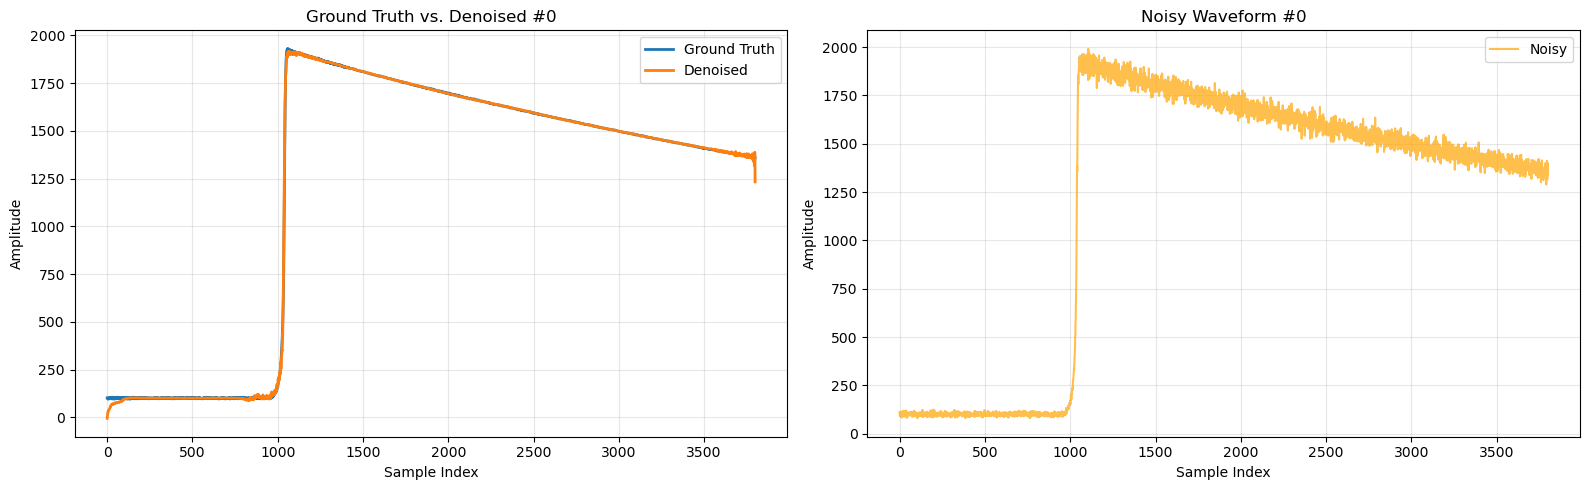

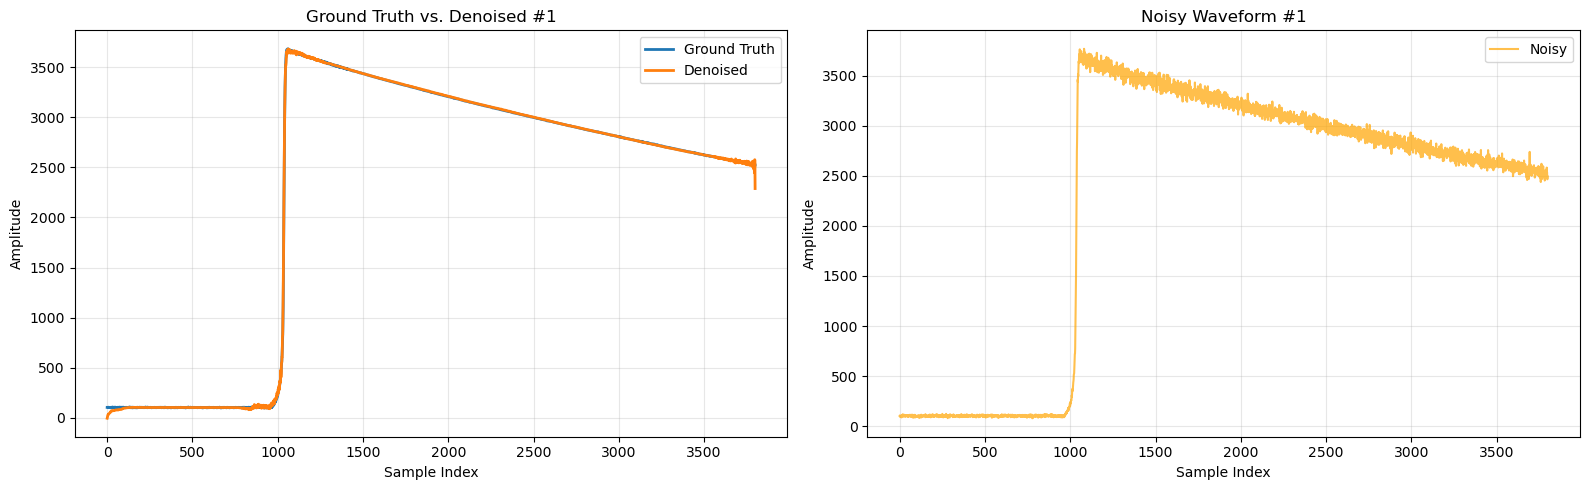

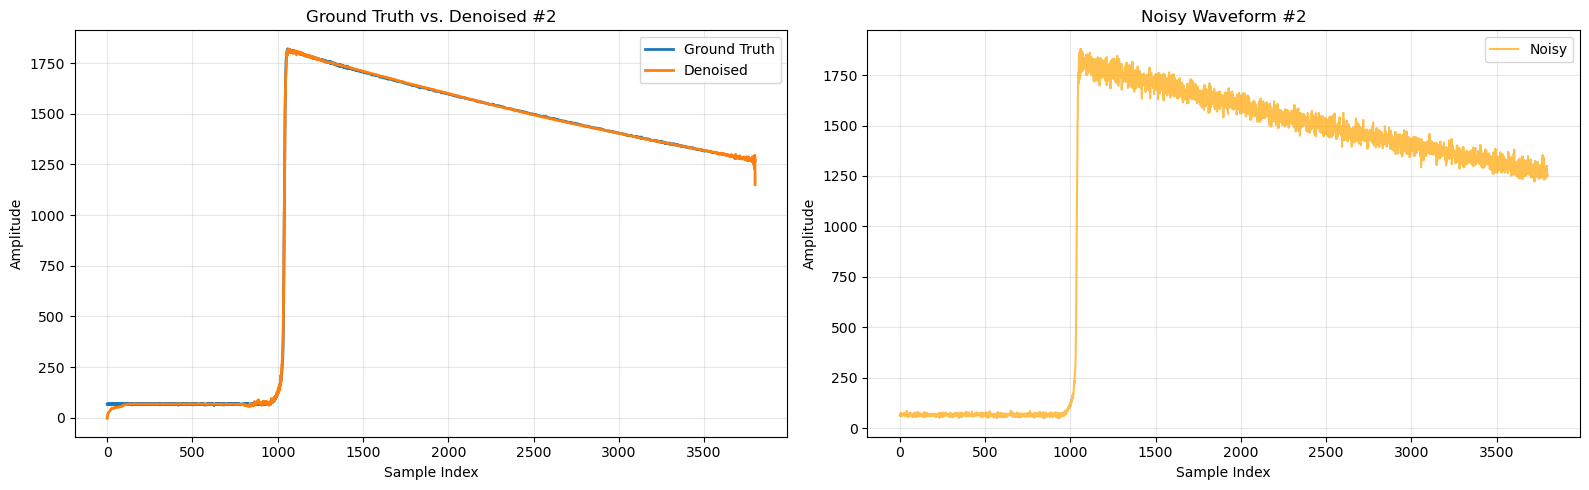

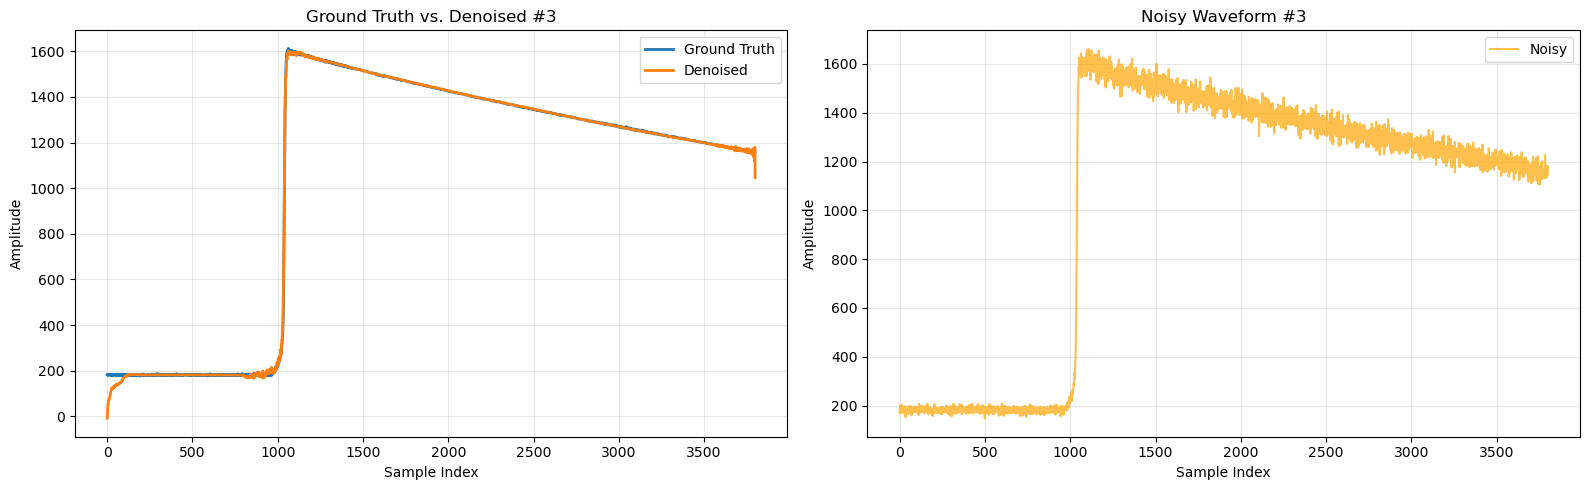

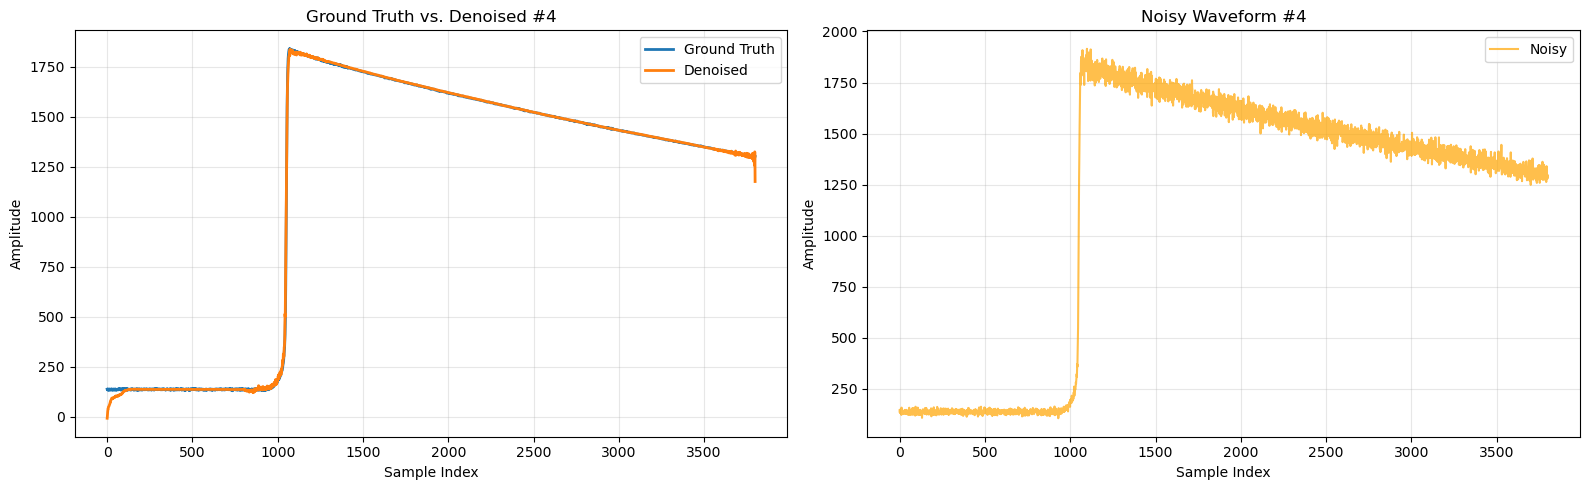

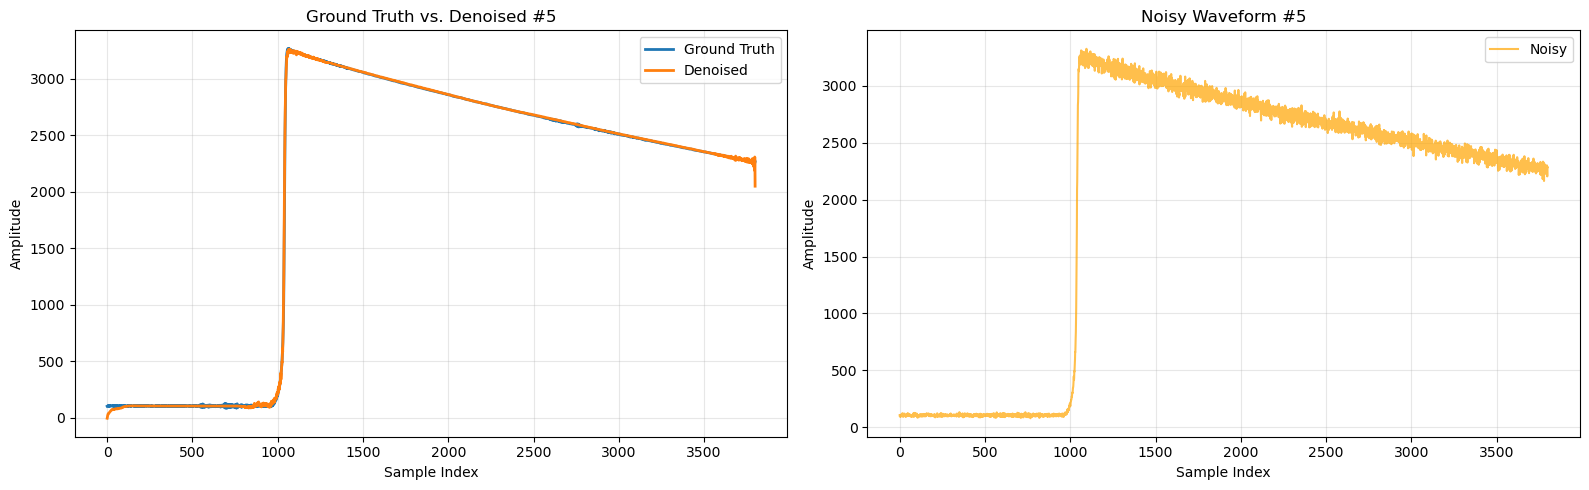

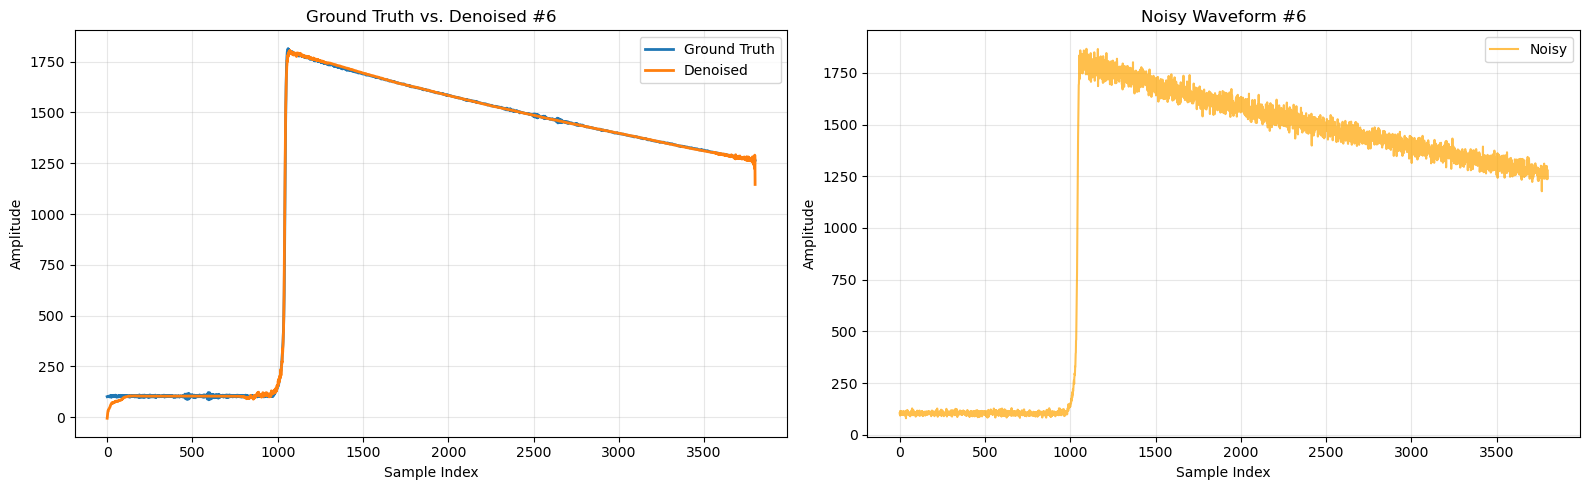

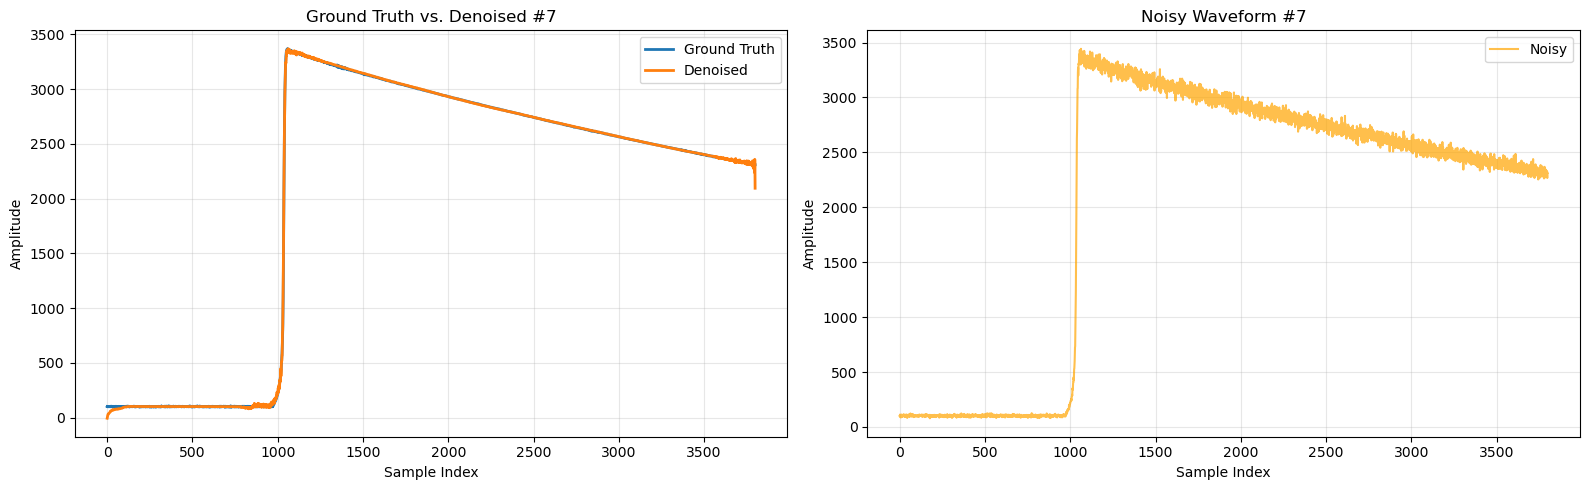

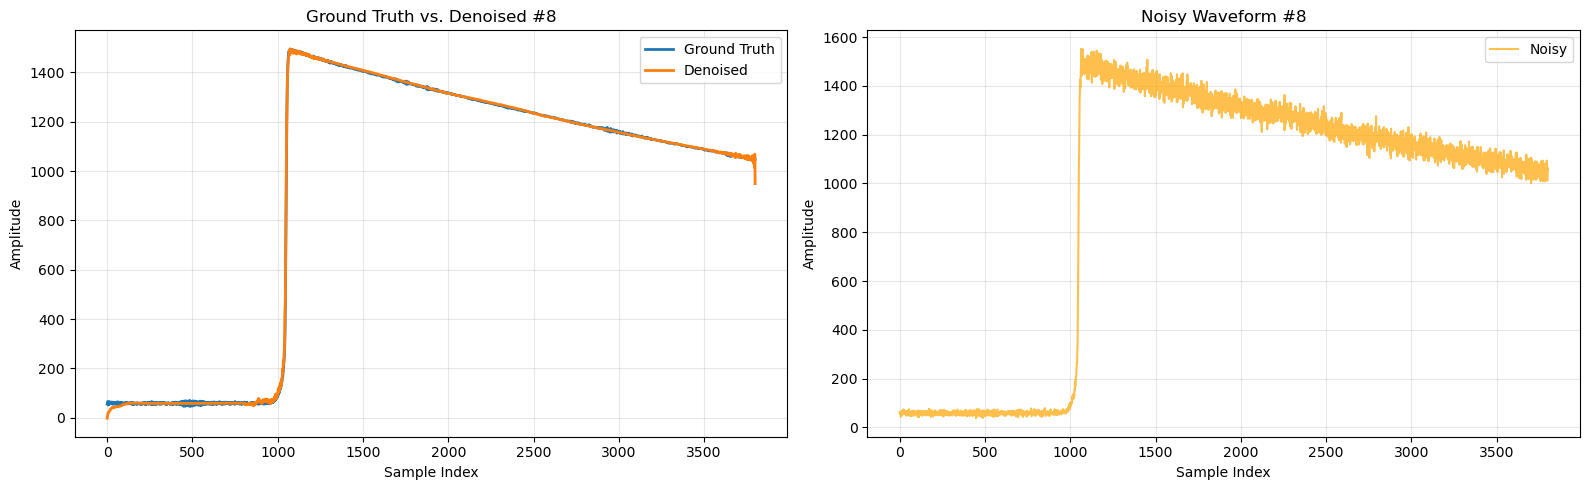

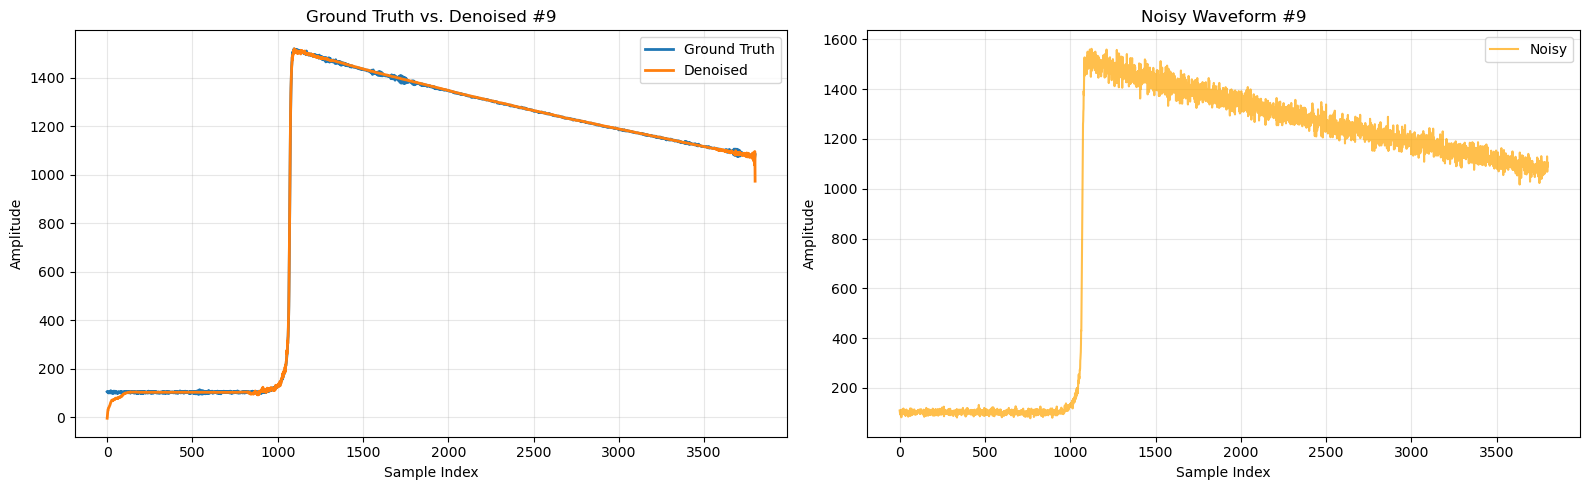

In [28]:
for i in range(10):
    gt = high_waveforms[i]
    nw = poisson_wf[i]
    dn = denoised_poisson[i].squeeze()   # handles (L,) or (L,1)

    fig, axs = plt.subplots(1, 2, figsize=(16,5))  # 1 row, 2 columns

    # Left plot: Ground Truth vs Denoised
    axs[0].plot(gt, label="Ground Truth", linewidth=2)
    axs[0].plot(dn, label="Denoised", linewidth=2)
    axs[0].set_title(f"Ground Truth vs. Denoised #{i}")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Amplitude")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Right plot: Noisy waveform
    axs[1].plot(nw, label="Noisy", alpha=0.7, color='orange')
    axs[1].set_title(f"Noisy Waveform #{i}")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## Validation of the denoise model in Fourier Space (frequency domain)

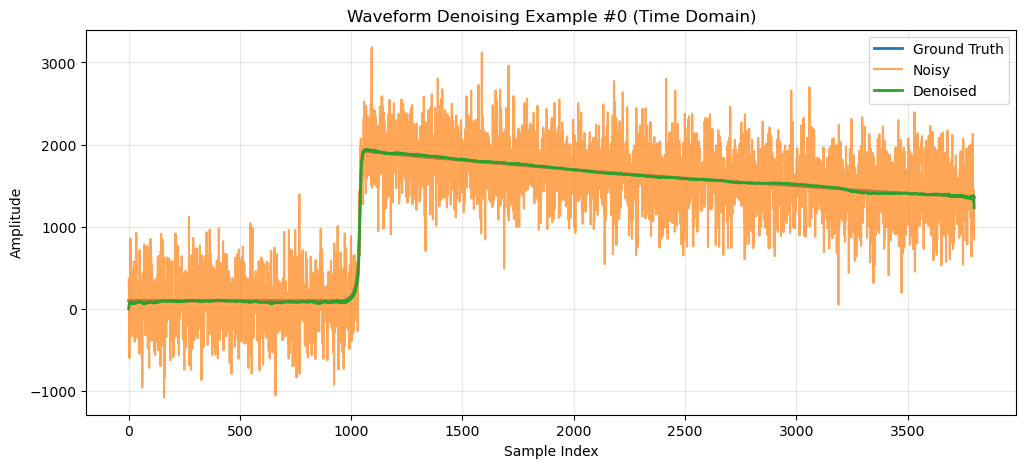

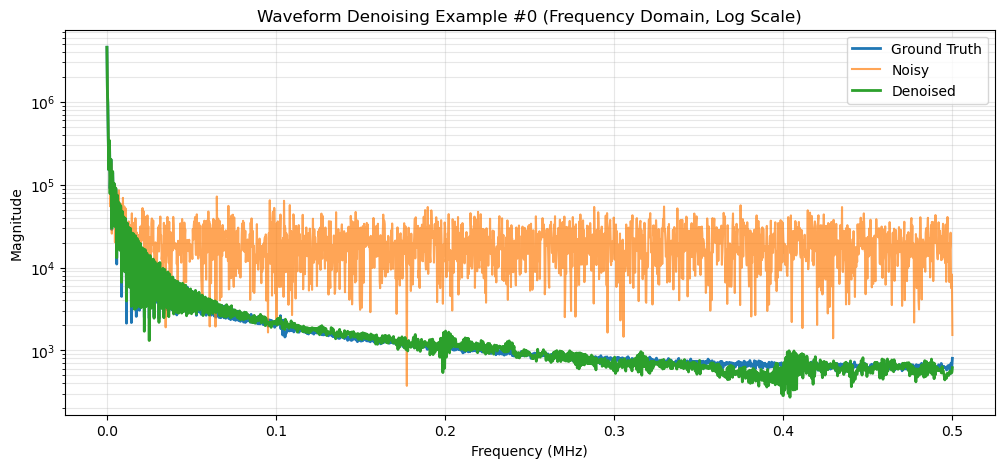

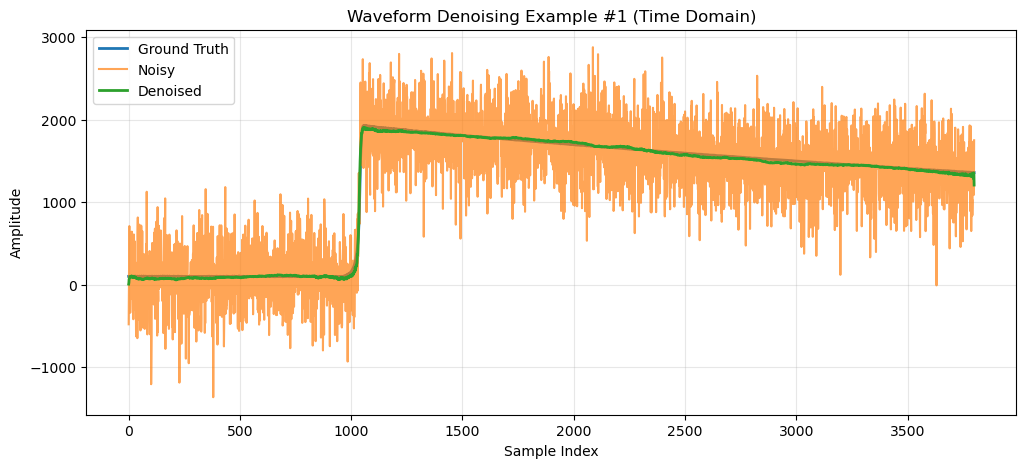

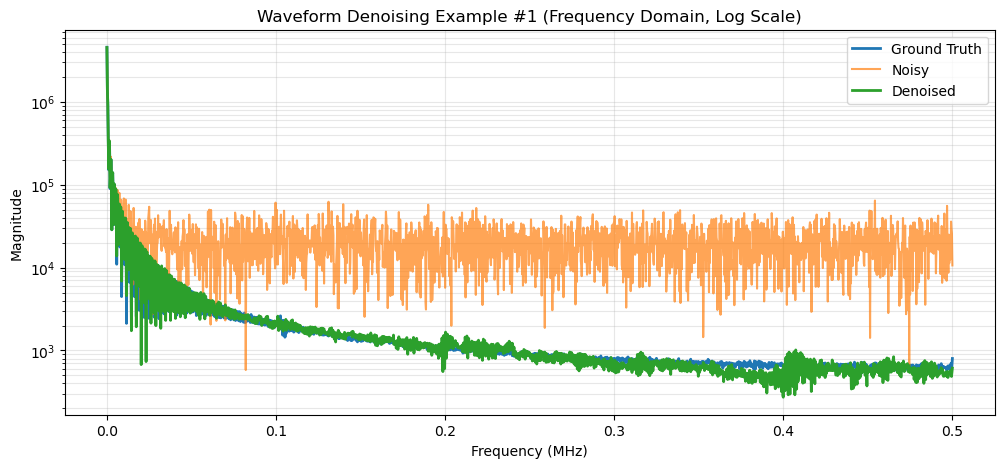

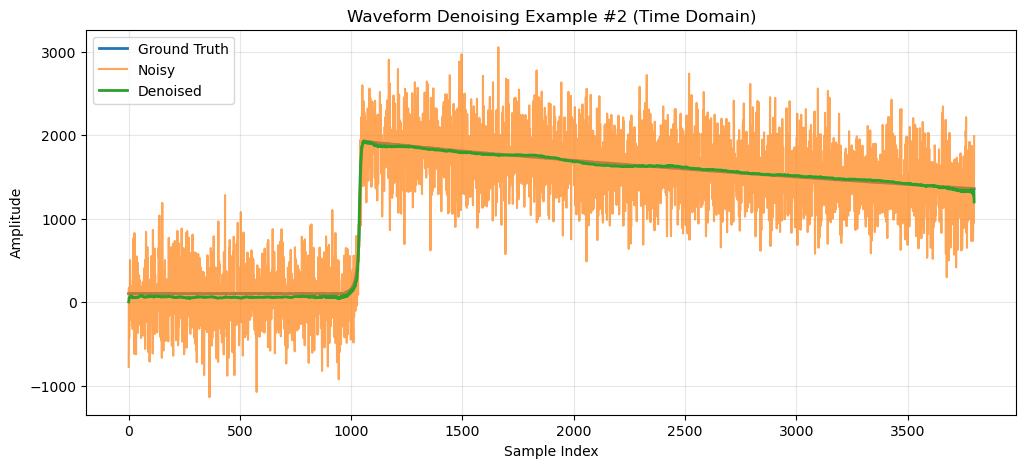

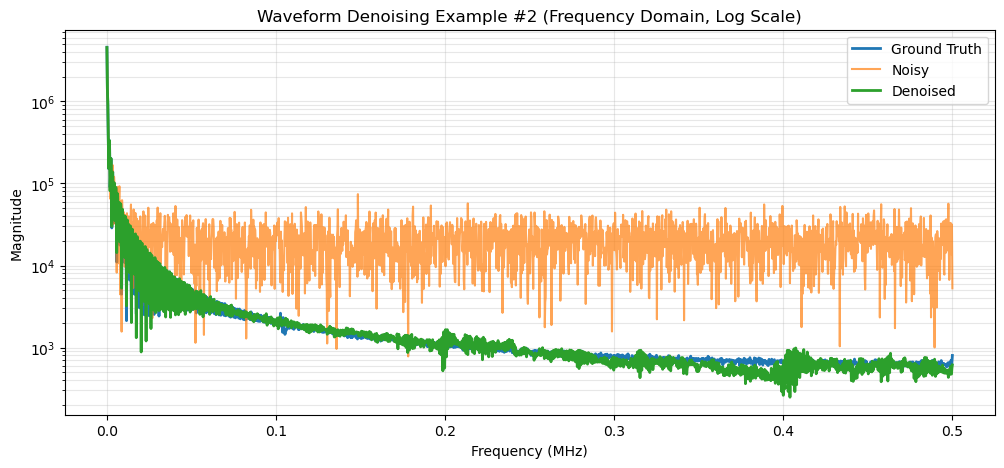

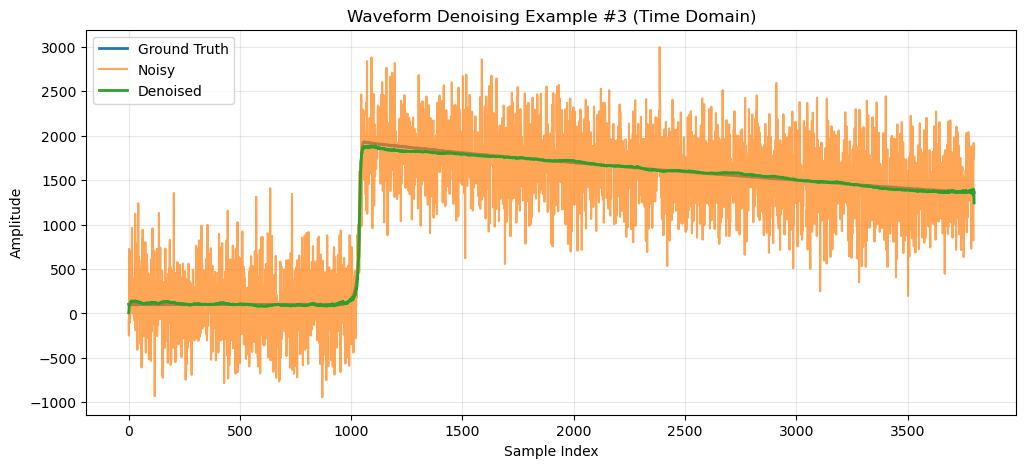

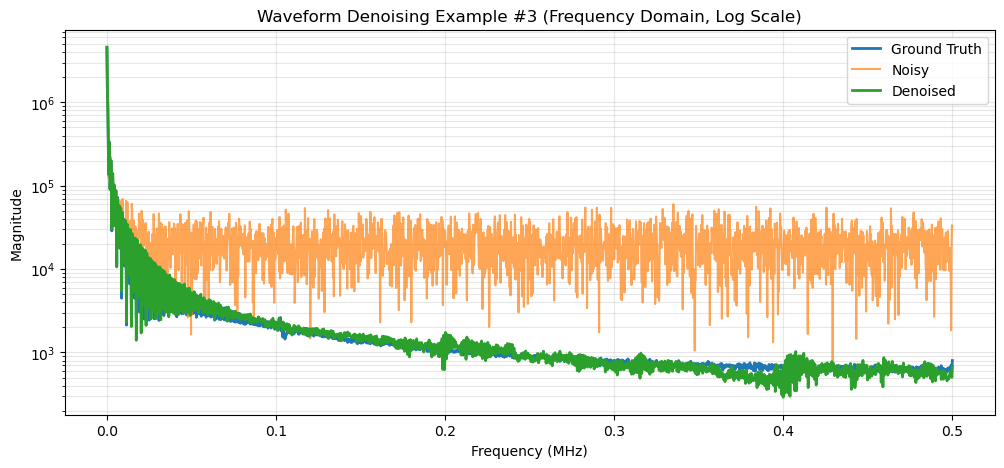

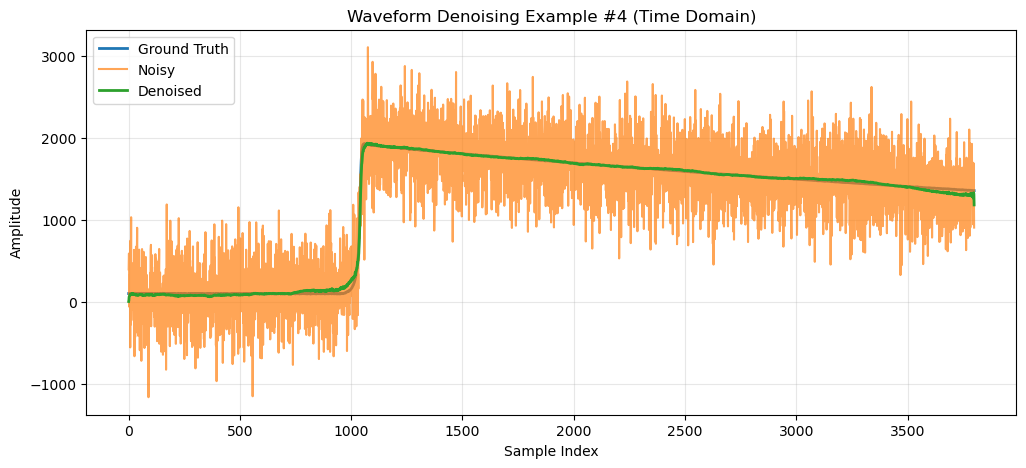

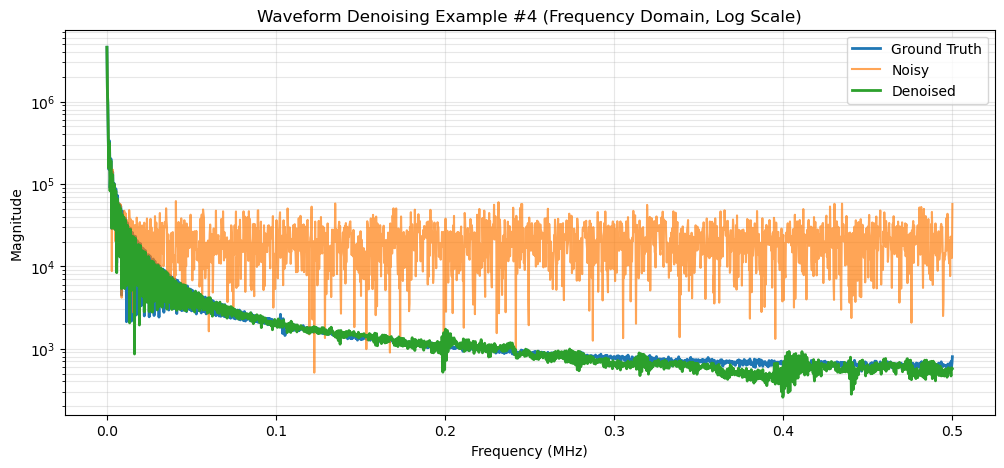

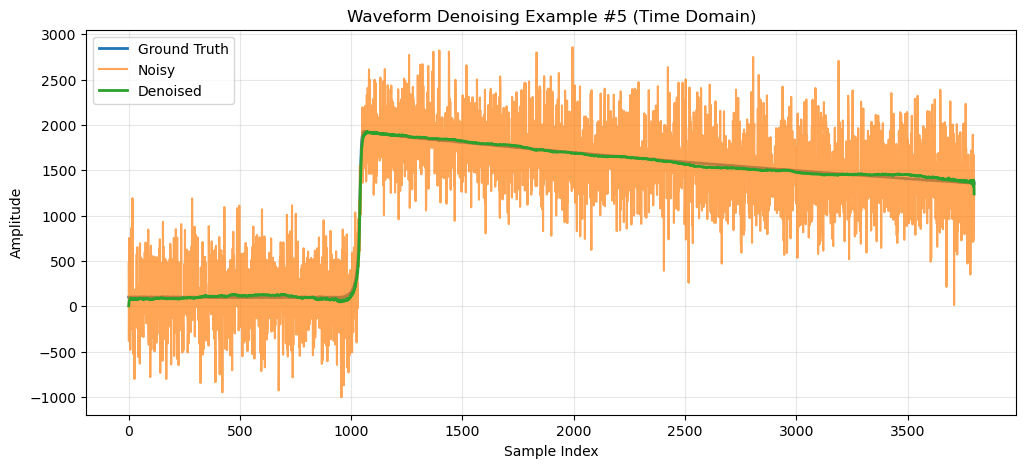

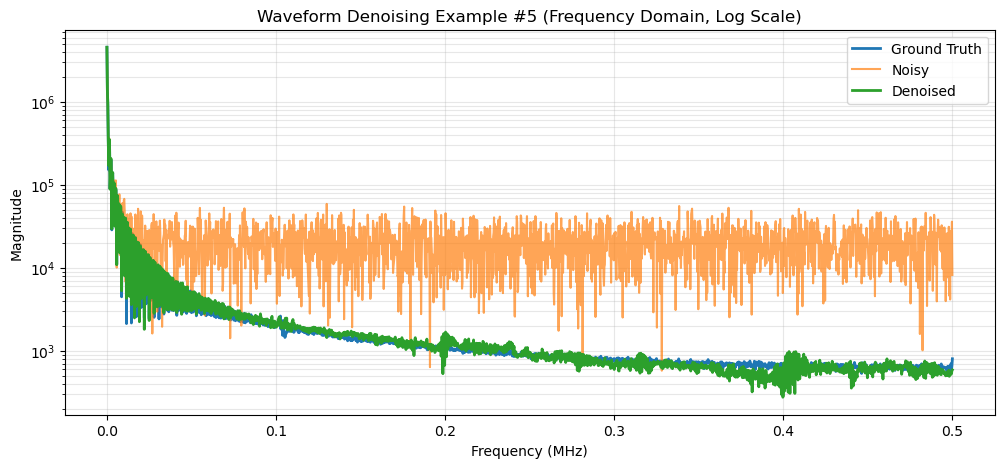

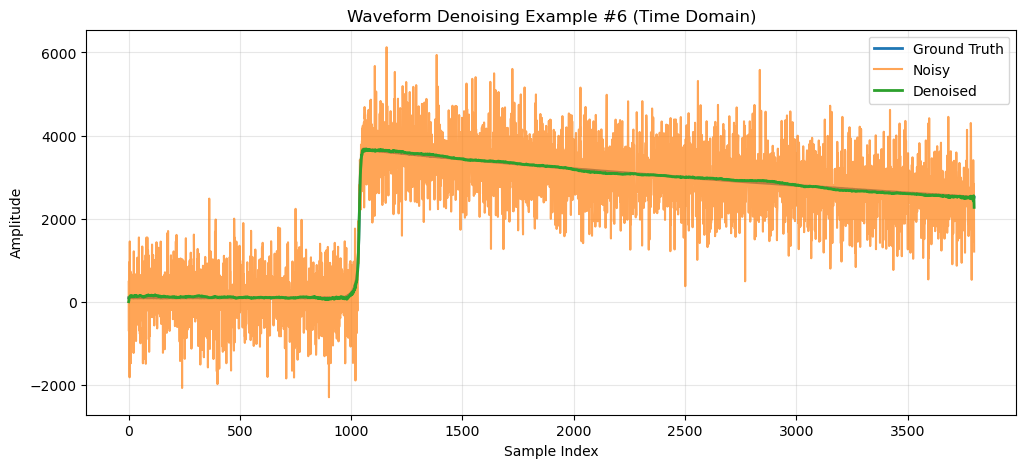

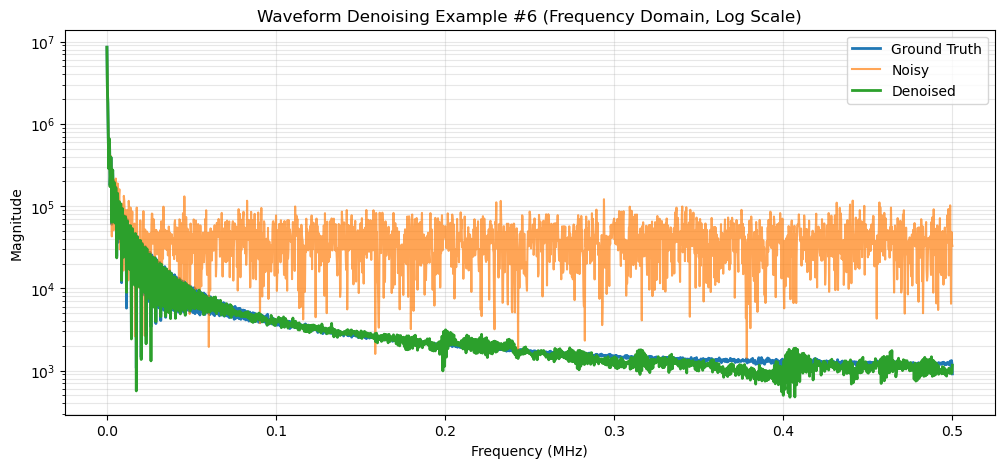

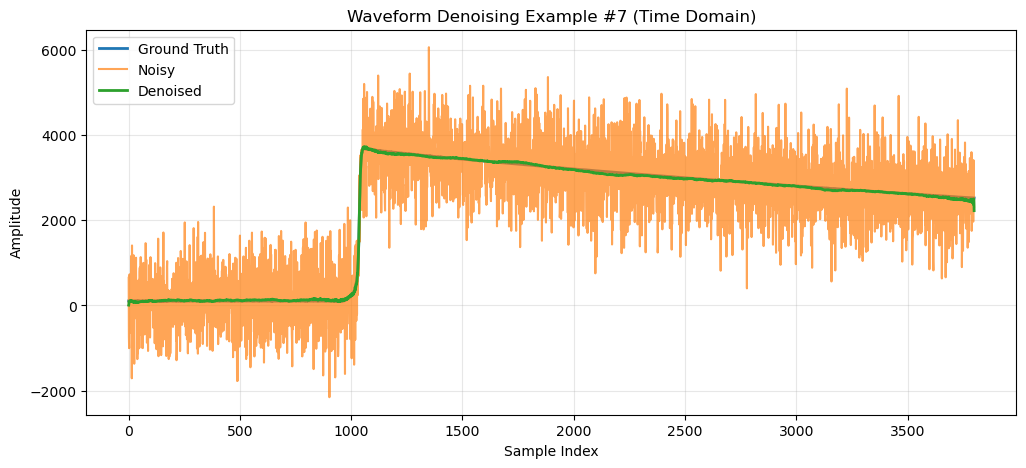

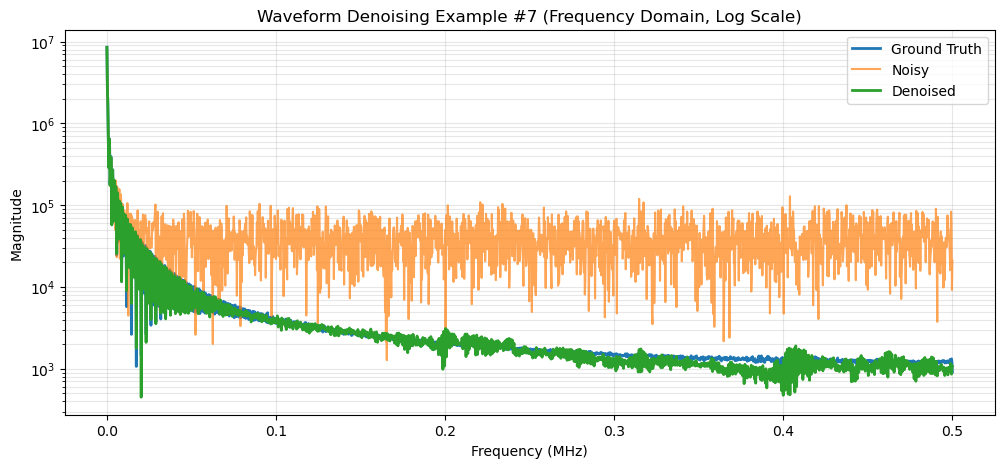

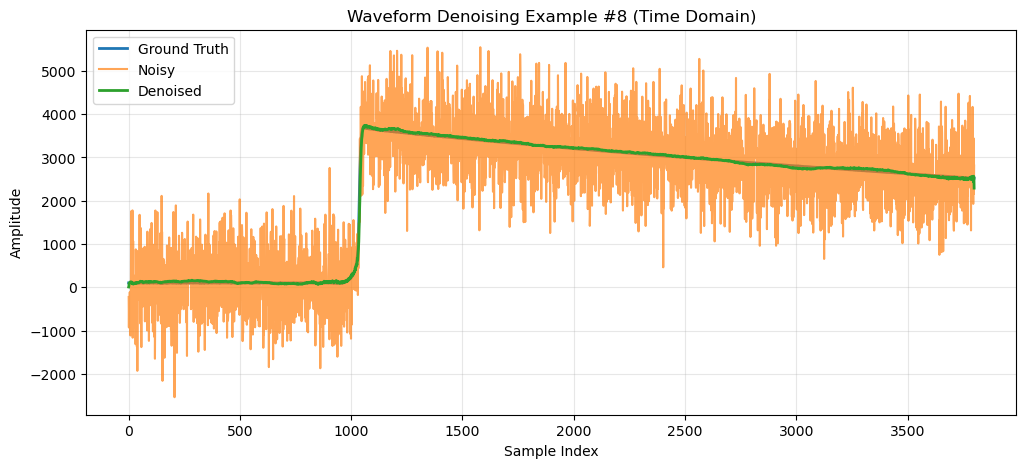

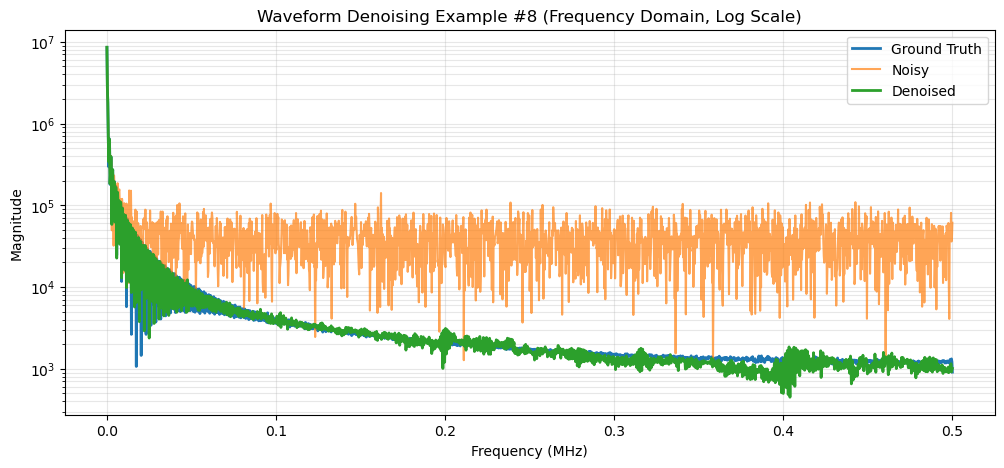

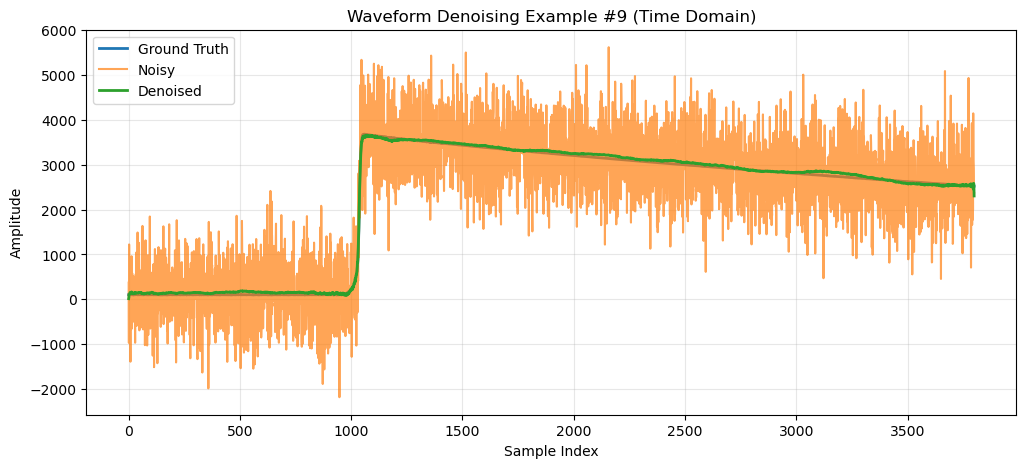

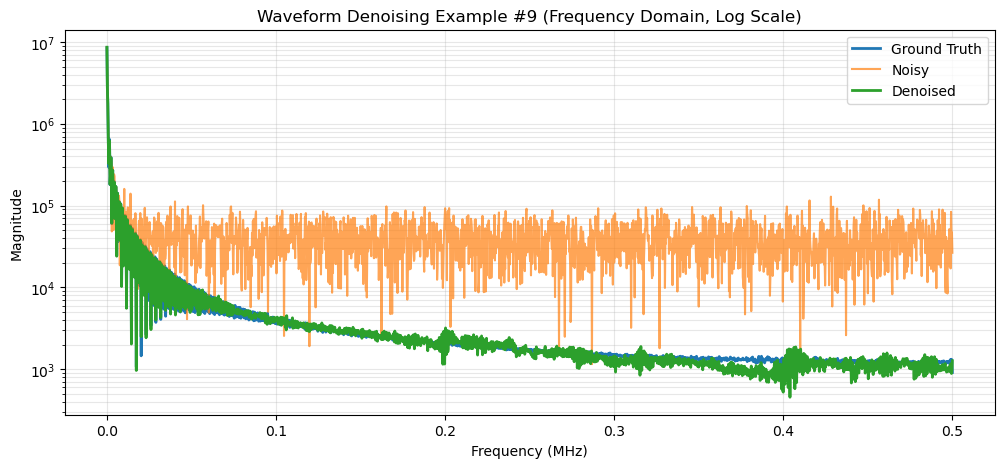

In [29]:
for i in range(10):
    gt = clean_shifted[i]
    nw = noisy[i]
    dn = denoised[i].squeeze()  # ensures shape (L,)

    # --- Time domain plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(gt, label="Ground Truth", linewidth=2)
    plt.plot(nw, label="Noisy", alpha=0.7)
    plt.plot(dn, label="Denoised", linewidth=2)
    plt.title(f"Waveform Denoising Example #{i} (Time Domain)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # --- Frequency domain plot ---
    gt_fft = np.fft.rfft(gt)
    nw_fft = np.fft.rfft(nw)
    dn_fft = np.fft.rfft(dn)

    L = len(gt)
    freqs = np.fft.rfftfreq(L, d=1)  # adjust d=1 if sampling interval is different

    plt.figure(figsize=(12, 5))
    plt.plot(freqs, np.abs(gt_fft), label="Ground Truth", linewidth=2)
    plt.plot(freqs, np.abs(nw_fft), label="Noisy", alpha=0.7)
    plt.plot(freqs, np.abs(dn_fft), label="Denoised", linewidth=2)
    plt.title(f"Waveform Denoising Example #{i} (Frequency Domain, Log Scale)")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude")
    plt.yscale("log")  # <-- log scale for magnitude
    plt.legend()
    plt.grid(alpha=0.3, which='both')  # grid works for log scale too
    plt.show()




## Testing model's performance on low-energy waveform with structural noise in the original dataset. 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


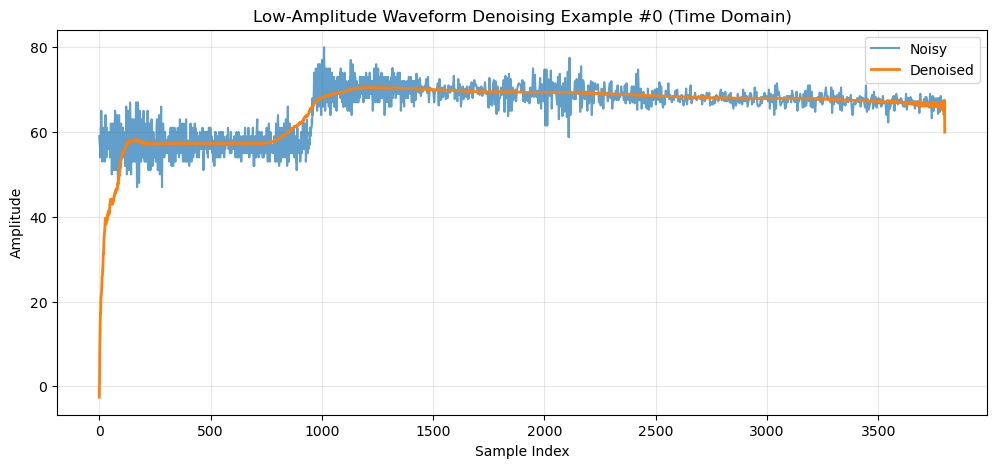

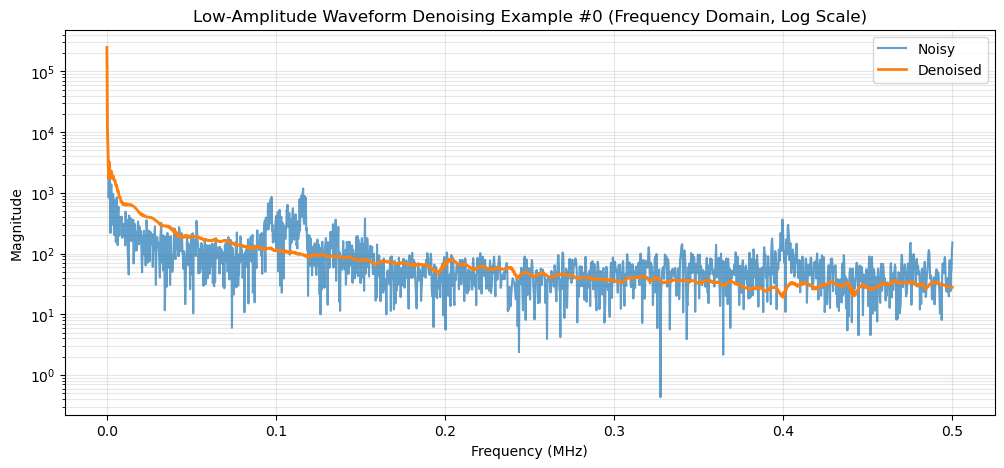

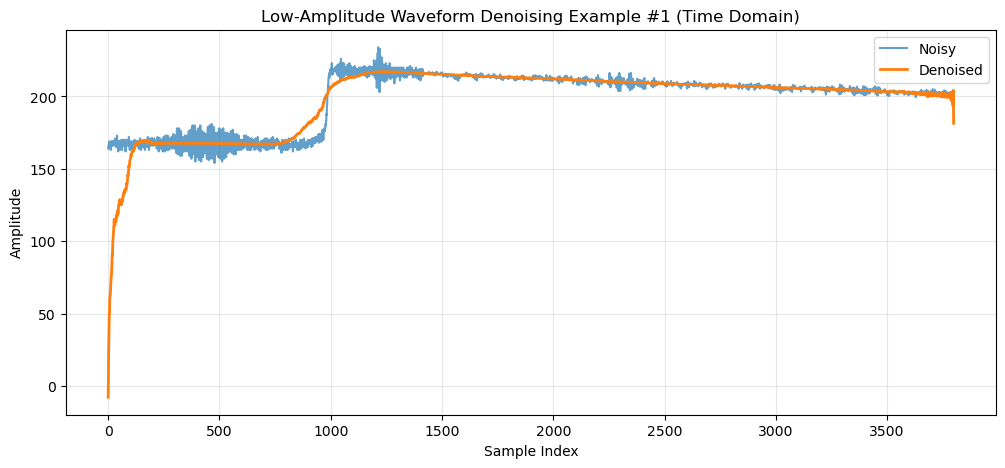

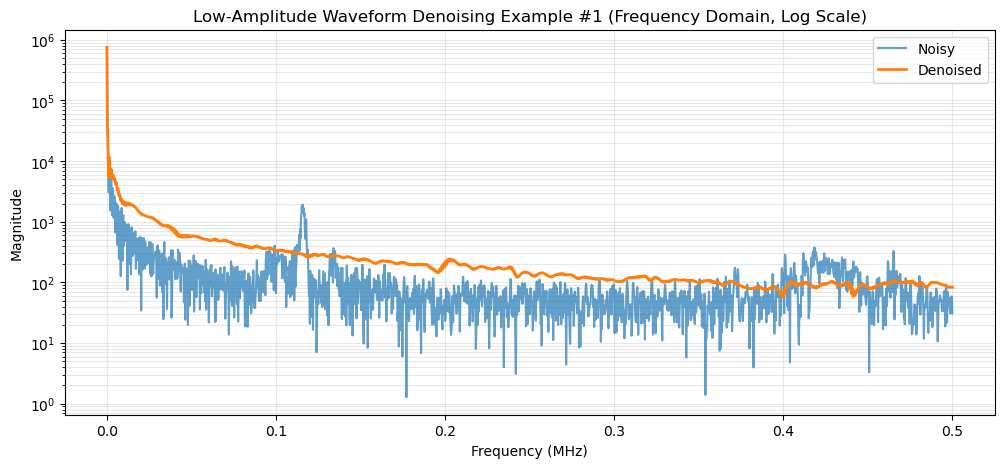

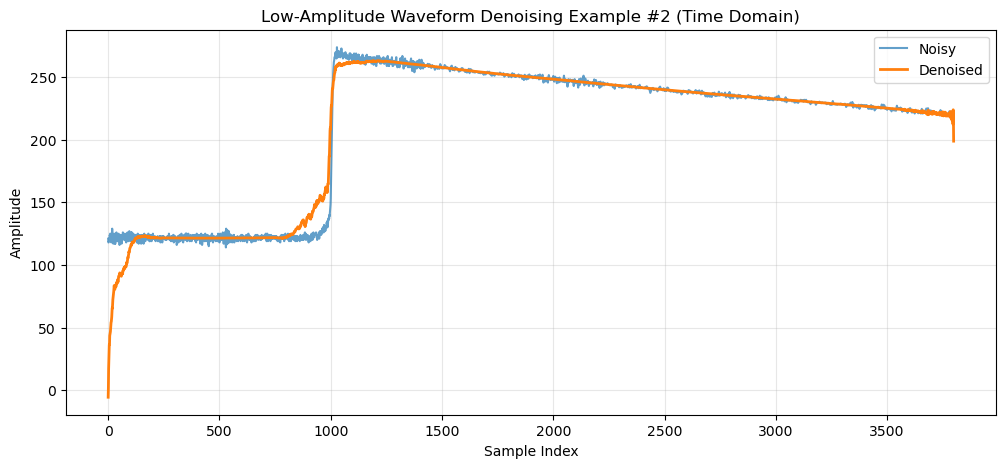

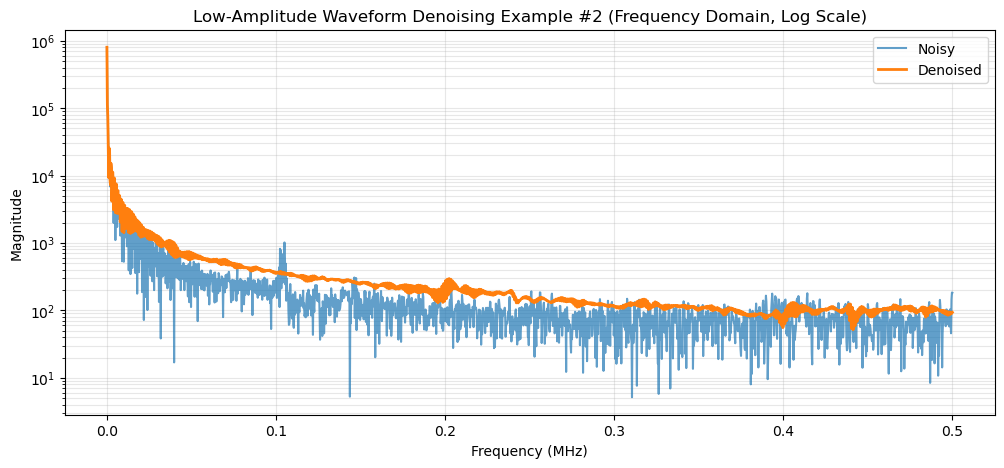

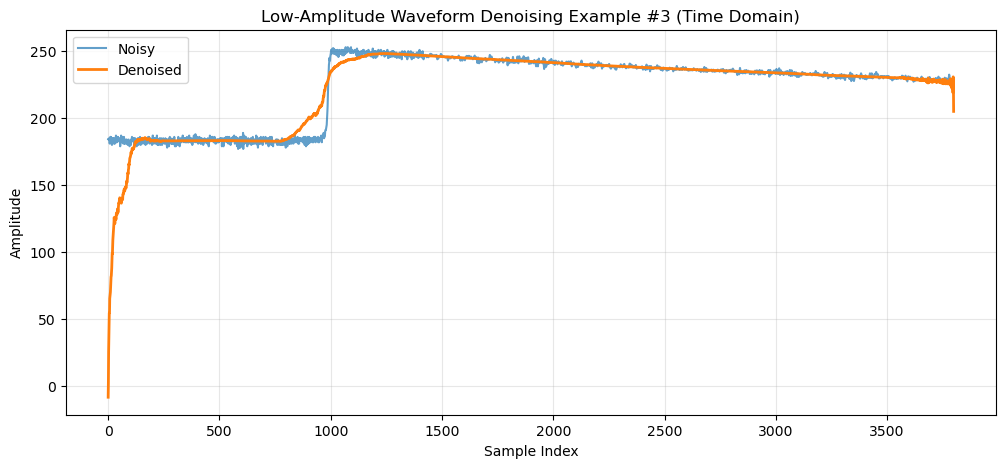

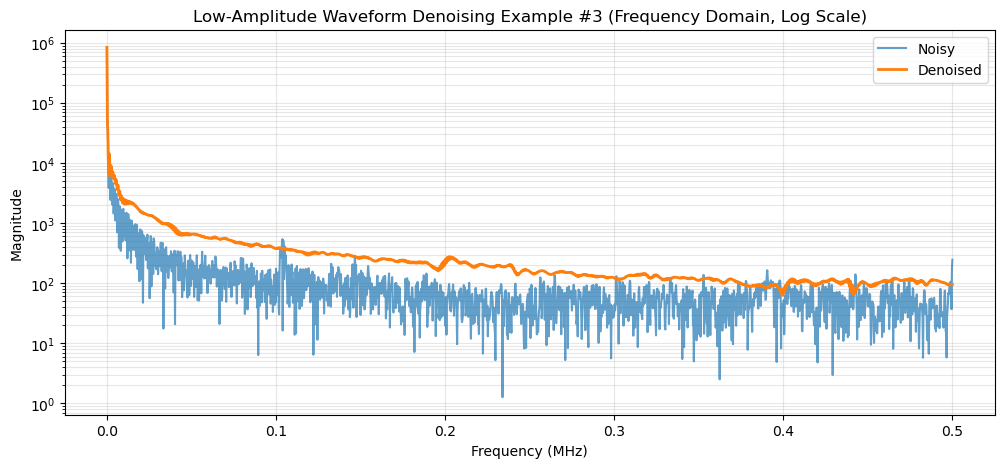

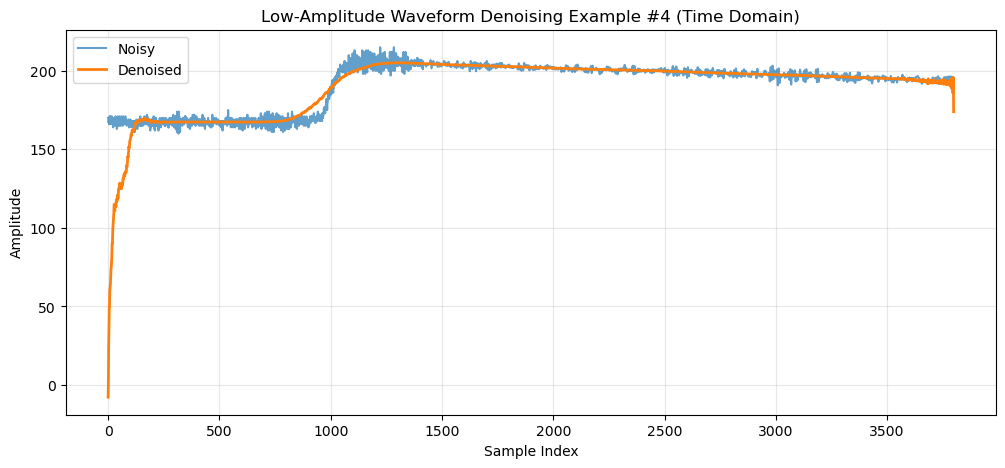

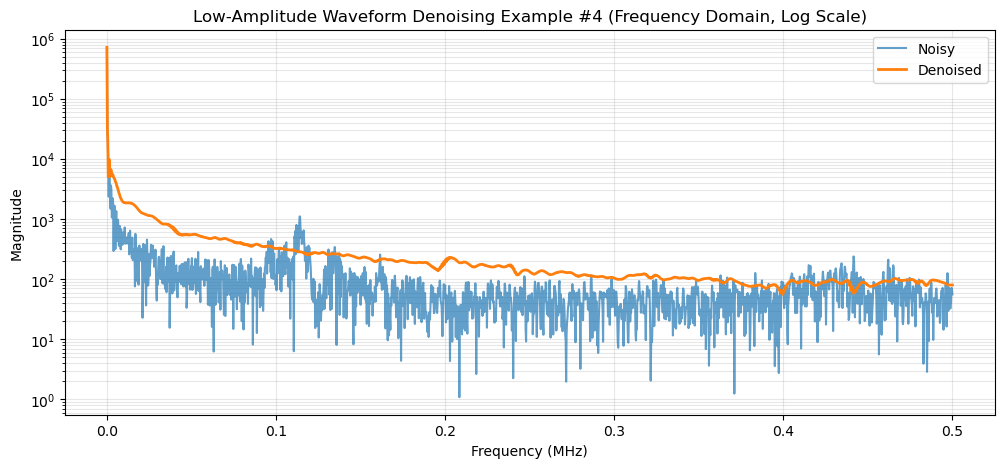

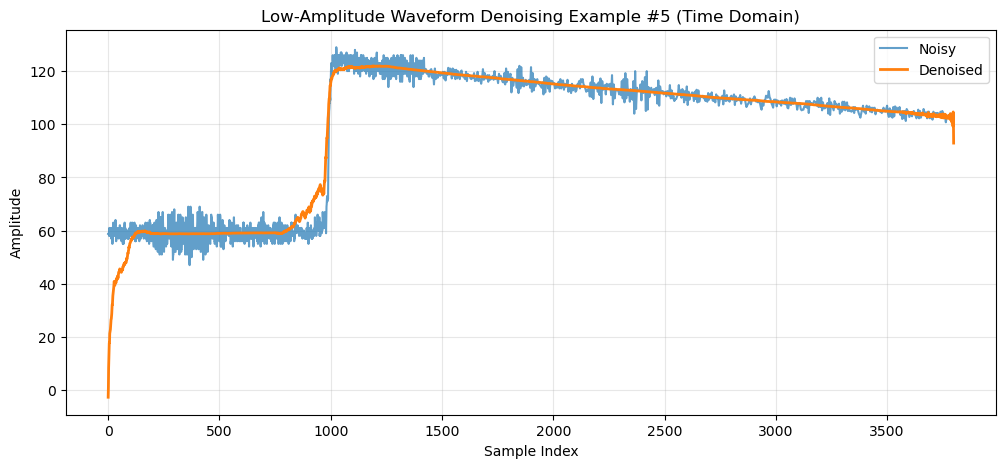

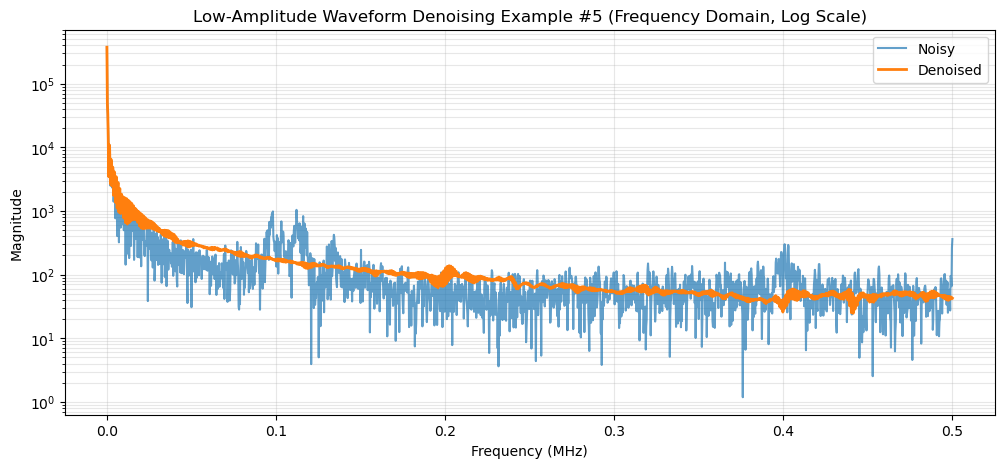

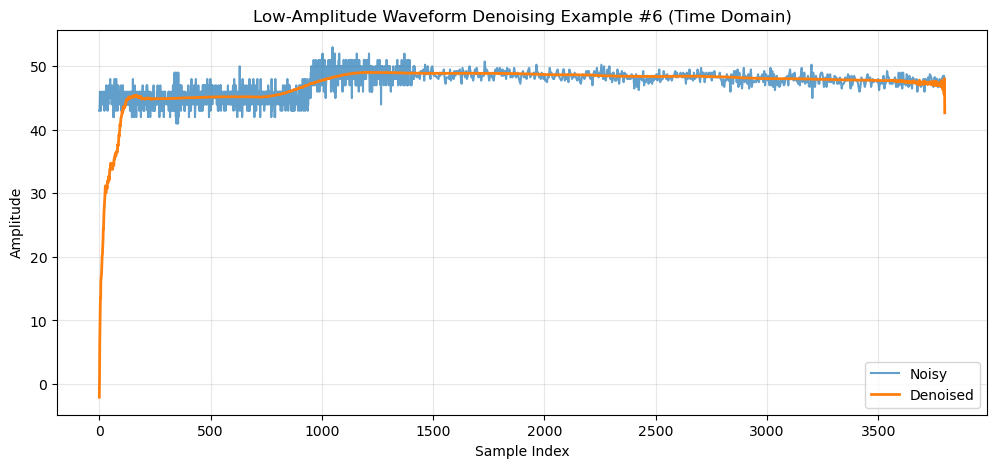

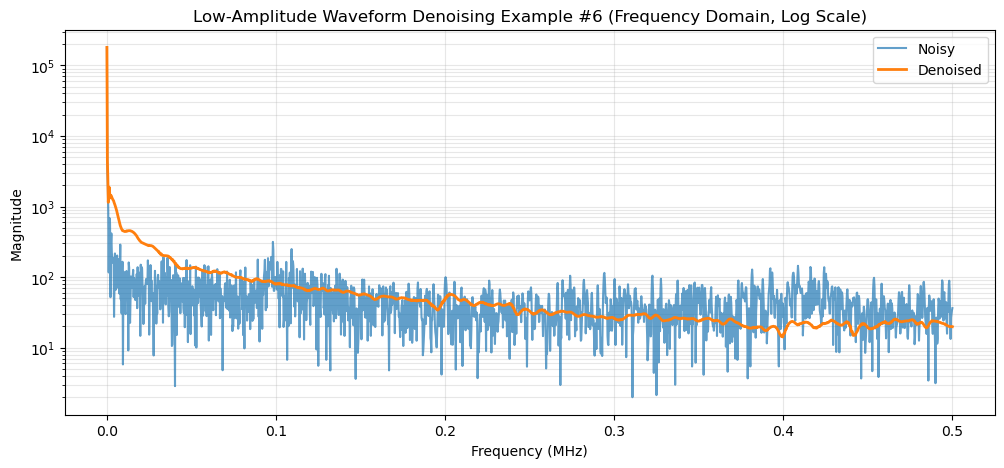

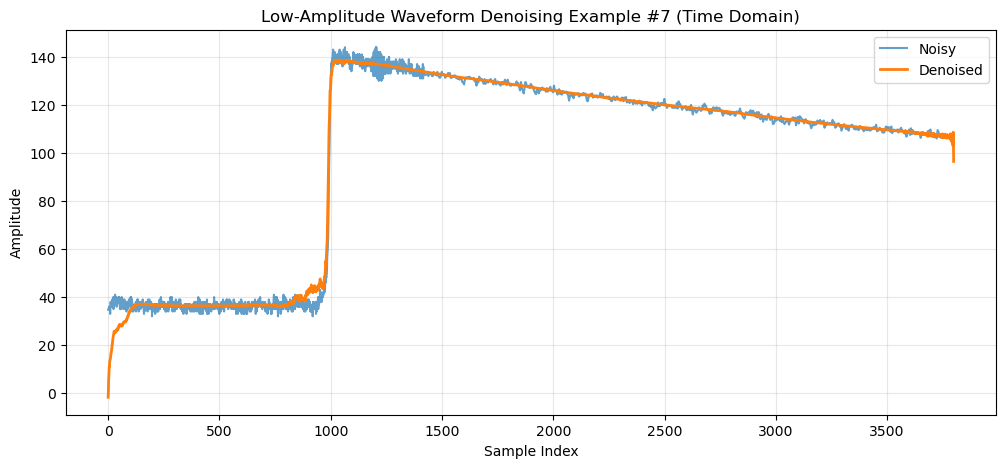

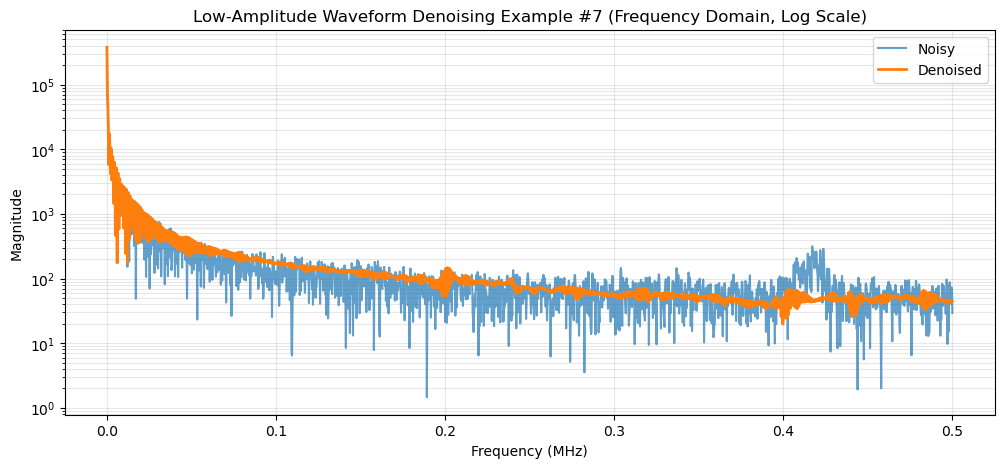

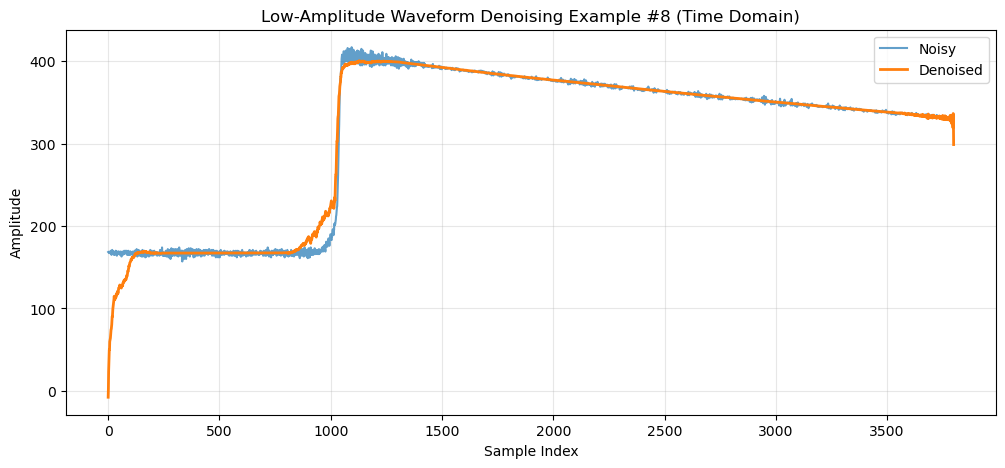

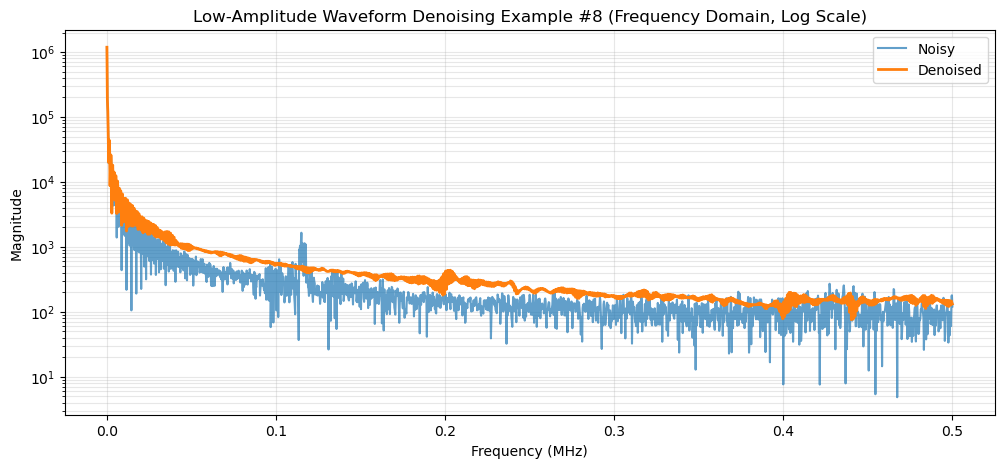

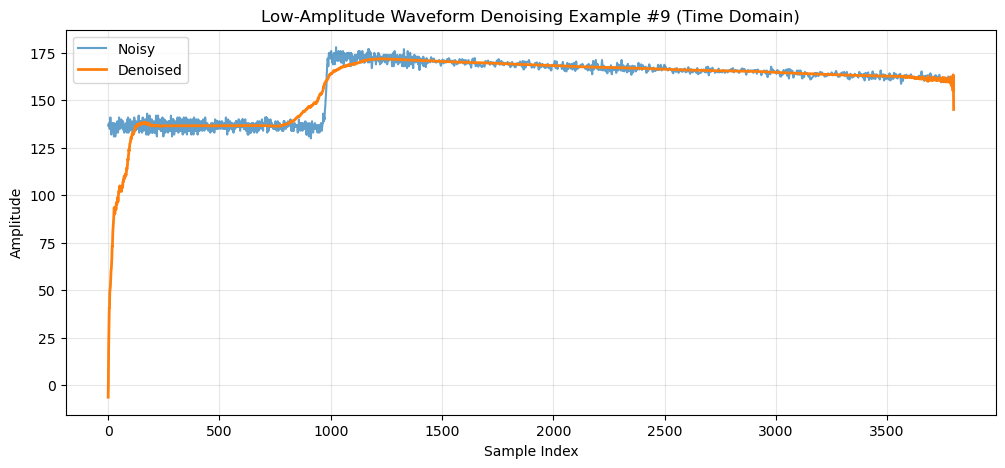

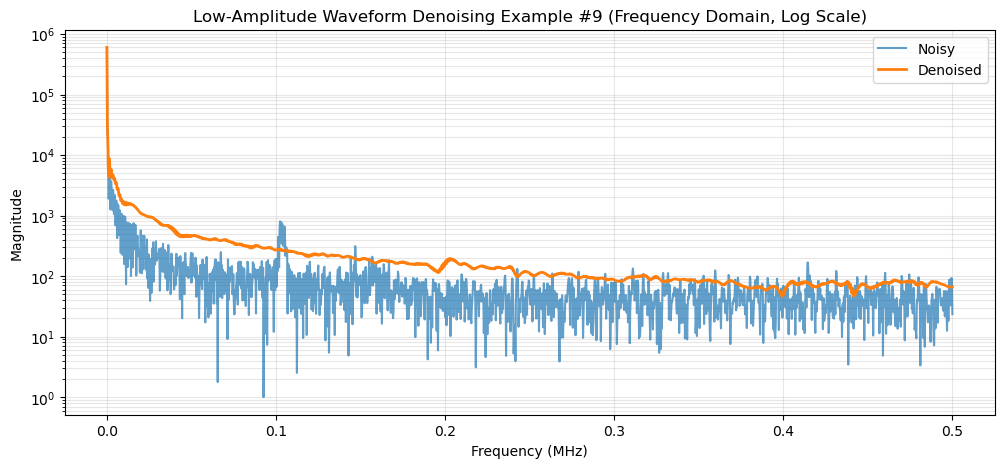

In [30]:
# low energy indices 
low_energy_indices = np.where(
    (sse_label == 1) & (energy_label <= 100)
)[0]
selected_low_waveforms = waveforms[low_energy_indices]

denoised_low = model_2.predict(selected_low_waveforms[..., None])
for i in range(10):
    nw = selected_low_waveforms[i]
    dn = denoised_low[i].squeeze()  # ensures shape (L,)

    # --- Time domain plot ---
    plt.figure(figsize=(12,5))
    plt.plot(nw, label="Noisy", alpha=0.7)
    plt.plot(dn, label="Denoised", linewidth=2)
    plt.title(f"Low-Amplitude Waveform Denoising Example #{i} (Time Domain)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # --- Frequency domain plot ---
    nw_fft = np.fft.rfft(nw)
    dn_fft = np.fft.rfft(dn)

    L = len(nw)
    freqs = np.fft.rfftfreq(L, d=1)  # adjust d if your sampling interval != 1

    plt.figure(figsize=(12,5))
    plt.plot(freqs, np.abs(nw_fft), label="Noisy", alpha=0.7)
    plt.plot(freqs, np.abs(dn_fft), label="Denoised", linewidth=2)
    plt.title(f"Low-Amplitude Waveform Denoising Example #{i} (Frequency Domain, Log Scale)")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude")
    plt.yscale("log")  # log scale for magnitude
    plt.legend()
    plt.grid(alpha=0.3, which='both')
    plt.show()


Keys: ['detector', 'energy_label', 'id', 'psd_label_dcr', 'psd_label_high_avse', 'psd_label_low_avse', 'psd_label_lq', 'raw_waveform', 'run_number', 'tp0']
Found 29087 single-site events in 30–1500 keV range


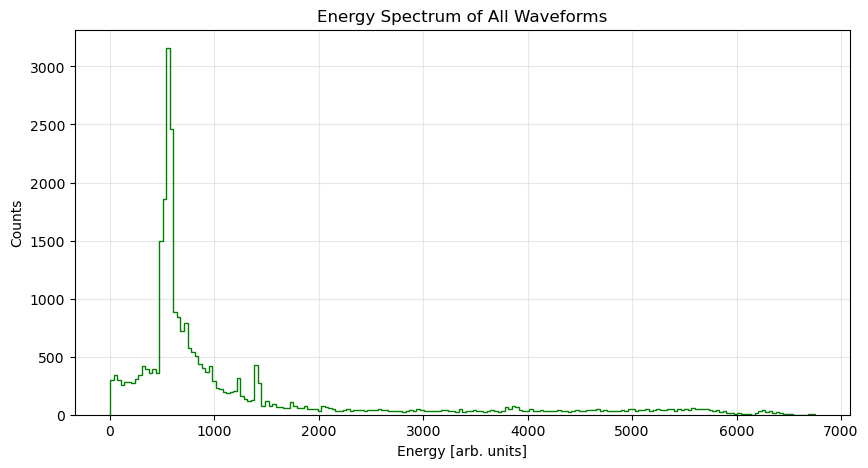

In [31]:
with h5py.File(filename, "r") as f:
    # Check available keys first
    print("Keys:", list(f.keys()))
    
    waveforms = f["raw_waveform"][:]                
    sse_label = f["psd_label_low_avse"][:]
    energy_label = f["energy_label"][:]
    rs_index = f["tp0"][:]

# Combine conditions: single-site AND energy between 30 and 1500 keV
combined_indices = np.where(
    (sse_label == 1)
)[0]

# Extract the waveforms and energies
selected_waveforms = waveforms[combined_indices]
selected_energies = energy_label[combined_indices]

print(f"Found {len(selected_waveforms)} single-site events in 30–1500 keV range")

def compute_energy(wf):

    """
    wf: np.array, waveform
    baseline_range: number of points to average for baseline
    rise_range: number of points to average for rising edge (signal)
    """
    baseline = np.mean(wf[300:700])
    rising_edge = np.mean(wf[1150:1200])  # assuming rising edge is at the end
    energy = rising_edge - baseline
    return energy

pure_energies = np.array([compute_energy(wf) for wf in selected_waveforms])

# --- Create the energy spectrum ---
plt.figure(figsize=(10,5))
plt.hist(pure_energies, bins=200, range=(np.min(pure_energies), np.max(pure_energies)), 
         histtype='step', color='green')
plt.xlabel("Energy [arb. units]")
plt.ylabel("Counts")
plt.title("Energy Spectrum of All Waveforms")
plt.grid(True, alpha=0.3)
plt.show()

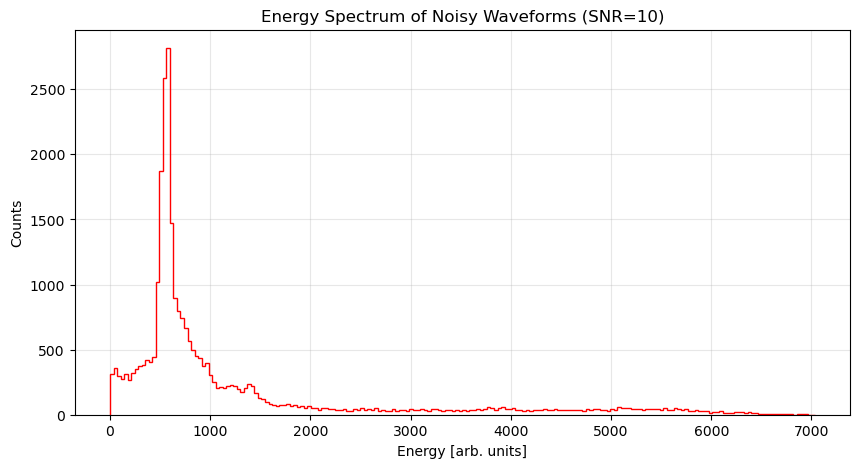

In [32]:
# --- Function to add Gaussian noise with target SNR ---
def add_gaussian_noise(signal, snr):
    """
    signal: np.array of shape (L,)
    snr: signal-to-noise ratio (linear, not dB)
    """
    signal_power = np.mean(signal**2)
    noise_power = signal_power / snr
    noise = np.random.normal(0, np.sqrt(noise_power), size=signal.shape)
    return signal + noise

# --- Add noise to all waveforms ---
snr = 10
noisy_waveforms_full = np.array([add_gaussian_noise(wf, snr) for wf in selected_waveforms])

# --- Function to compute energy from waveform ---

# --- Compute energies of noisy waveforms ---
noisy_energies = np.array([compute_energy(wf) for wf in noisy_waveforms_full])

# --- Plot histogram of noisy energies ---
plt.figure(figsize=(10,5))
plt.hist(noisy_energies, bins=200, range=(np.min(noisy_energies), np.max(noisy_energies)), 
         histtype='step', color='red')
plt.xlabel("Energy [arb. units]")
plt.ylabel("Counts")
plt.title("Energy Spectrum of Noisy Waveforms (SNR=10)")
plt.grid(True, alpha=0.3)
plt.show()

909/909 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step


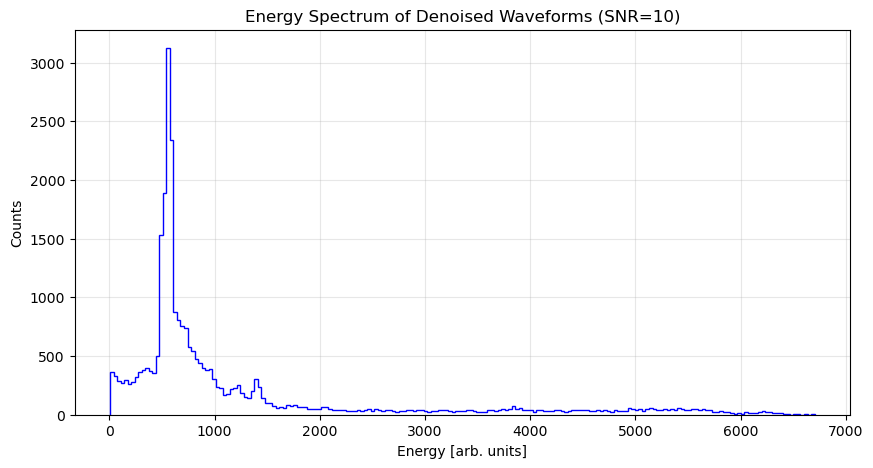

In [33]:
denoised_full = model_2.predict(noisy_waveforms_full[..., None])
clean_energies = np.array([compute_energy(wf) for wf in denoised_full.squeeze()])
# --- Plot histogram of noisy energies ---
plt.figure(figsize=(10,5))
plt.hist(clean_energies, bins=200, range=(np.min(clean_energies), np.max(clean_energies)), 
         histtype='step', color='blue')
plt.xlabel("Energy [arb. units]")
plt.ylabel("Counts")
plt.title("Energy Spectrum of Denoised Waveforms (SNR=10)")
plt.grid(True, alpha=0.3)
plt.show()

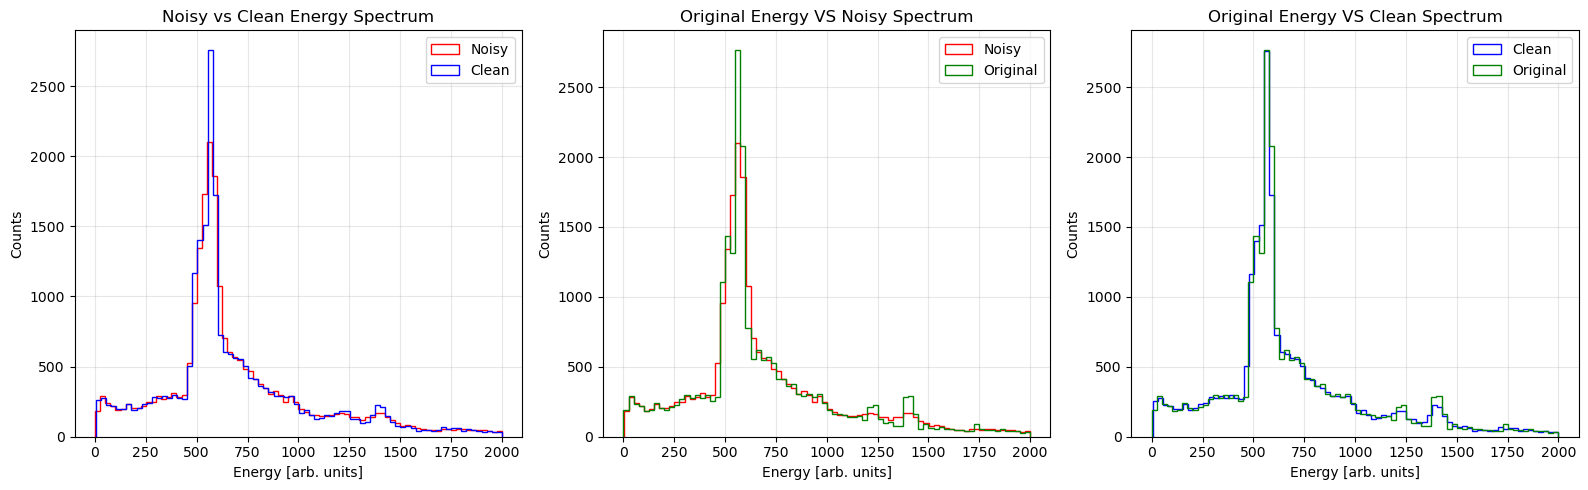

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Left plot: Noisy and Clean energies overlaid
ax1.hist(noisy_energies, bins=80, range=(np.min(noisy_energies), 2000), 
         histtype='step', color='red', label='Noisy', linewidth=1.0)
ax1.hist(clean_energies, bins=80, range=(np.min(clean_energies), 2000), 
         histtype='step', color='blue', label='Clean', linewidth=1.0)
ax1.set_xlabel("Energy [arb. units]")
ax1.set_ylabel("Counts")
ax1.set_title("Noisy vs Clean Energy Spectrum")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Pure energies
ax2.hist(noisy_energies, bins=80, range=(np.min(noisy_energies), 2000), 
         histtype='step', color='red', label='Noisy', linewidth=1.0)
ax2.hist(pure_energies, bins=80, range=(np.min(pure_energies), 2000), 
         histtype='step', color='green', label='Original', linewidth=1.0)
ax2.set_xlabel("Energy [arb. units]")
ax2.set_ylabel("Counts")
ax2.set_title("Original Energy VS Noisy Spectrum")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Right plot: Pure energies
ax3.hist(clean_energies, bins=80, range=(np.min(clean_energies), 2000), 
         histtype='step', color='blue', label='Clean', linewidth=1.0)
ax3.hist(pure_energies, bins=80, range=(np.min(pure_energies), 2000), 
         histtype='step', color='green', label='Original', linewidth=1.0)
ax3.set_xlabel("Energy [arb. units]")
ax3.set_ylabel("Counts")
ax3.set_title("Original Energy VS Clean Spectrum")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()